In [1]:
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
from numba import njit

from mpmath import coulombf
import rose
from osiris import BinarySPTree
from rose.training import multiple_formatter

In [2]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib import rcParams

colors = [
     "#1f77b4",  
     "#ff7f0e",
     "#2ca02c",
     "#d62728", 
     "#9467bd",
     "#8c564b",
     "#e377c2",
     "#7f7f7f",
     "#bcbd22",
     "#17becf",  
 ]
             
                 
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams["text.latex.preamble"]  = r"\usepackage{amssymb} \usepackage{amsmath}"
plt.rc("text", usetex=True)
 
rcParams["legend.fontsize"] = 9
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"


## Get training and test solutions

In [3]:
read_from_file = True

In [4]:
params = np.load("./global_kd_params.npy")
lower_bound = np.min(params, axis=(0, 1))
lower_bound[0] = 1e-1
upper_bound = np.max(params, axis=(0, 1))
bounds = np.vstack([lower_bound, upper_bound]).T
frozen_params = bounds[:,1] == bounds[:,0]

In [5]:
bounds

array([[ 1.00000000e-01,  5.00000000e+01],
       [ 9.27253291e+02,  9.83439040e+02],
       [ 3.24862646e+01,  5.09474947e+01],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 8.71746944e-02,  4.80302097e+00],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 2.67172625e+00,  6.73960839e+00],
       [ 5.40178569e+00,  7.01274719e+00],
       [ 5.15620000e-01,  5.32014400e-01],
       [ 4.85189971e+00,  6.27749683e+00],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-3.74068604e-01, -5.36334245e-03],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [6]:
# use log(E) space
scaleE = 1.0
def forward_pspace_transform(sample):
    return np.hstack([ np.log(sample[0]/scaleE), sample[1:]])

def backward_pspace_transform(sample):
    return np.hstack([np.exp(sample[0])*scaleE, sample[1:]])

In [7]:
# sample parameters in log(E) space
log_energy_bounds = bounds.copy()
log_energy_bounds = np.vstack(
    [
        forward_pspace_transform(log_energy_bounds[:,0]).T,
        forward_pspace_transform(log_energy_bounds[:,1]).T,
    ]).T
log_energy_bounds

array([[-2.30258509e+00,  3.91202301e+00],
       [ 9.27253291e+02,  9.83439040e+02],
       [ 3.24862646e+01,  5.09474947e+01],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 8.71746944e-02,  4.80302097e+00],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 2.67172625e+00,  6.73960839e+00],
       [ 5.40178569e+00,  7.01274719e+00],
       [ 5.15620000e-01,  5.32014400e-01],
       [ 4.85189971e+00,  6.27749683e+00],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-3.74068604e-01, -5.36334245e-03],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [8]:
from rose.training import latin_hypercube_sample
if read_from_file:
    train = np.load("train.npy")
    test = np.load("test.npy")
else:
    train = latin_hypercube_sample(2000, log_energy_bounds, seed=13)
    test = latin_hypercube_sample(300, log_energy_bounds, seed=11)
    np.save("train.npy", np.asarray(train))
    np.save("test.npy", np.asarray(test))

In [9]:
# transform back to E space
train[:,0] = np.exp(train[:,0])
test[:,0] = np.exp(test[:,0])

In [10]:
l_max=10
angles = np.linspace(0, np.pi, 200)
s_mesh = np.linspace(1e-2, 5 * np.pi, 1000)
domain = np.array([s_mesh[0], s_mesh[-1]])
s_0 = 4.9 * np.pi

In [11]:
free_solns = np.zeros((l_max, s_mesh.size), dtype=np.complex128)
for l in range(l_max):
    free_solns[l,:] = np.array([ coulombf(l,0,s) for s in s_mesh], dtype=np.complex128)

In [12]:
interactions = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=bounds,
    n_basis=15,
    l_max=l_max,
    n_train=10,
)
sae = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interaction_space=interactions,
    angles=angles,
    s_mesh=s_mesh,
)

/home/kyle/umich/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)


In [13]:
if not read_from_file:
    hf_solns_up = np.zeros((len(train), l_max+1, s_mesh.size), dtype=np.complex128)
    hf_solns_down = np.zeros((len(train), l_max, s_mesh.size), dtype=np.complex128)

    for i, sample in enumerate(train):
        solns = sae.exact_wave_functions(sample)
        hf_solns_up[i,...] = np.array([x[0] for x in solns])
        hf_solns_down[i,...] = np.array([x[1] for x in solns[1:]])

    np.save("hf_solns_up.npy", hf_solns_up, )
    np.save("hf_solns_down.npy", hf_solns_down )
else:
    hf_solns_down = np.load("hf_solns_down.npy")
    hf_solns_up = np.load("hf_solns_up.npy")

In [14]:
if not read_from_file:
    smatrix_surface_up = np.zeros((len(train), l_max), dtype=np.complex128)
    smatrix_surface_down = np.zeros((len(train), l_max), dtype=np.complex128)

    for i, sample in enumerate(train):
        splus, sminus = sae.exact_smatrix_elements(sample)
        smatrix_surface_up[i,...] = splus
        smatrix_surface_down[i,...] = sminus

    np.save("smatrix_solns_up.npy", smatrix_surface_up)
    np.save("smatrix_solns_down.npy", smatrix_surface_down )
else:
    smatrix_surface_up = np.load("smatrix_solns_up.npy")
    smatrix_surface_down = np.load("smatrix_solns_down.npy")

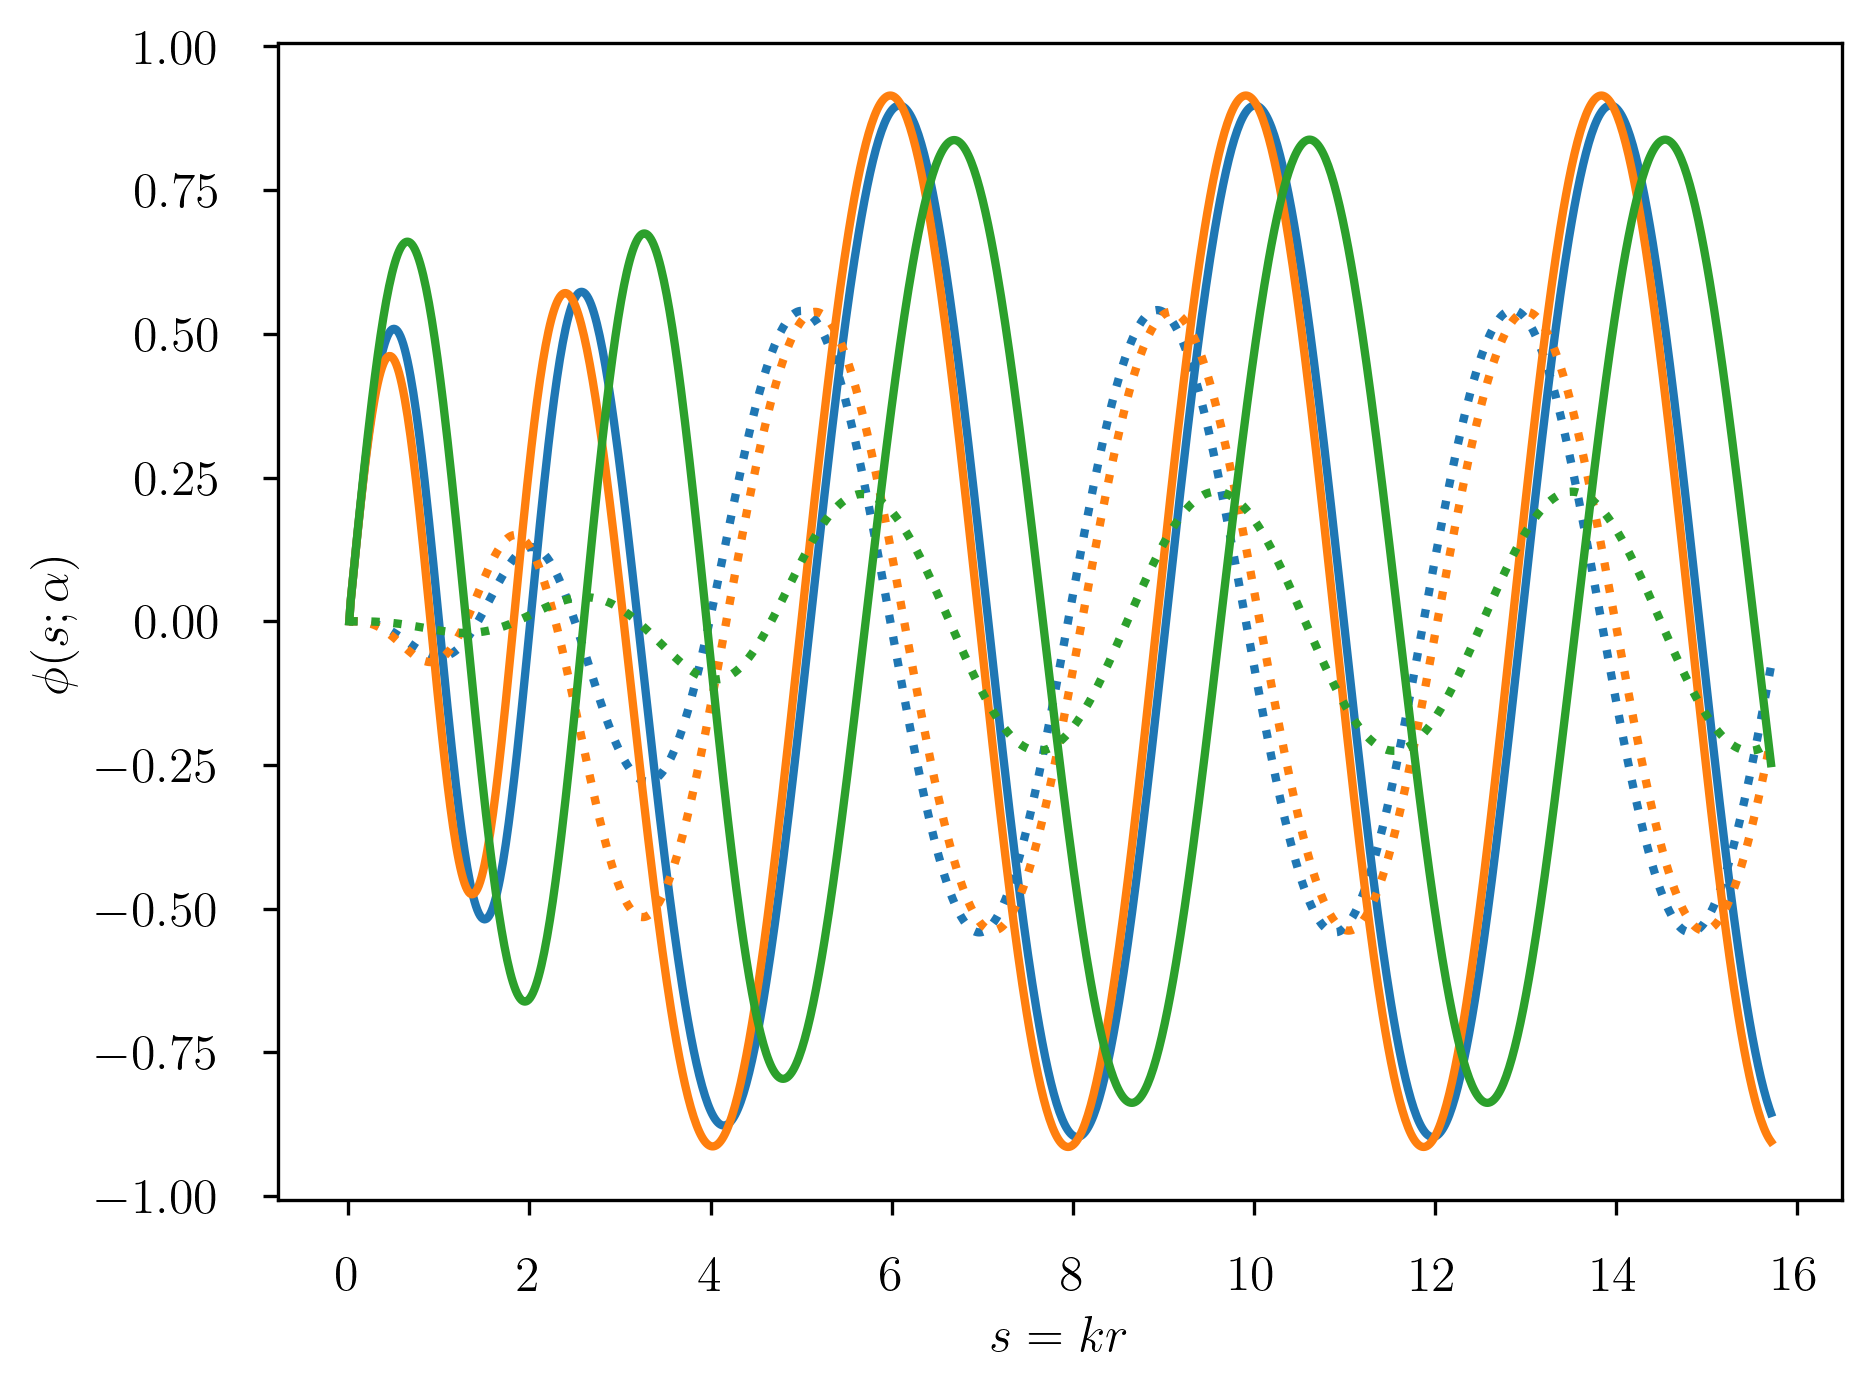

In [15]:
f = plt.figure(facecolor="white", dpi=300)
for i, sample in enumerate(train[:3]):
    p = plt.plot(s_mesh, hf_solns_up[i, 0, :].real)[0]
    plt.plot(
        s_mesh,
        hf_solns_up[i, 0, :].imag,
        ":",
        color=p.get_color(),
    )
plt.xlabel(r"$s = kr$")
plt.ylabel(r"$\phi(s; \alpha)$")
plt.tight_layout()

## Discover the Active Subspace

In [16]:
from scipy.spatial import kdtree

In [17]:
# pre process training data
train_transformed = train.copy()
train_transformed[:, 0] = np.log(train_transformed[:, 0])
train_mean = np.mean(train_transformed, axis=0)
train_pp = (train_transformed - train_mean) / (
    log_energy_bounds[:, 1] - log_energy_bounds[:, 0]
)
train_pp[:, frozen_params] = 0


def pre_process(sample):
    x = (forward_pspace_transform(sample) - train_mean) / (
        log_energy_bounds[:, 1] - log_energy_bounds[:, 0]
    )
    x[frozen_params] = 0
    return x

/tmp/ipykernel_46051/1800520247.py:5: RuntimeWarning: divide by zero encountered in divide
  train_pp = (train_transformed - train_mean) / (


In [18]:
tree = kdtree.KDTree(train_pp)

/tmp/ipykernel_46051/3789304619.py:1: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  tree = kdtree.KDTree(train_pp)


In [19]:
k = 200
lcut = 4
gradient_vector_samples = np.zeros(
    (train.shape[0] * (lcut*2), train.shape[1]), dtype=np.double
)

for i in range(train.shape[0]):
    sample = train[i,:]
    ds, idxs = tree.query(pre_process(sample), k=k)
    smatrix = np.hstack([smatrix_surface_down[i, :lcut], smatrix_surface_up[i, :lcut]])
    max_delta_idxs = np.zeros( (lcut *2 ), dtype=np.int32)
    deltas = np.zeros(lcut *2 )
    for d, j in zip(ds, idxs):
        smatrix_neighbor = np.hstack(
            [smatrix_surface_down[j, :lcut], smatrix_surface_up[j, :lcut]]
        )
        delta_j = np.absolute(smatrix_neighbor - smatrix) / np.abs(d) #/ np.absolute(smatrix)
        mask = delta_j > deltas
        deltas[mask] = delta_j[mask]
        max_delta_idxs[mask] = int(j)
    
    gradient_vector_samples[i : i + (lcut*2), :] = [
        (train_pp[x, :] - train_pp[i,:]) / 
        np.sqrt(np.dot(train_pp[x, :] - train_pp[i,:], train_pp[x, :] - train_pp[i,:])) 
        for x in max_delta_idxs
    ]

/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (
/tmp/ipykernel_46051/1663508680.py:17: RuntimeWarning: invalid value encountered in divide
  delta_j = np.absolute(smatrix_neighbor - smatrix) / np.abs(d) #/ np.absolute(smatrix)


In [20]:
U, S, Vh = np.linalg.svd(gradient_vector_samples.T, full_matrices=False)
print(U.shape, S.shape, Vh.shape)

(17, 17) (17,) (17, 16000)


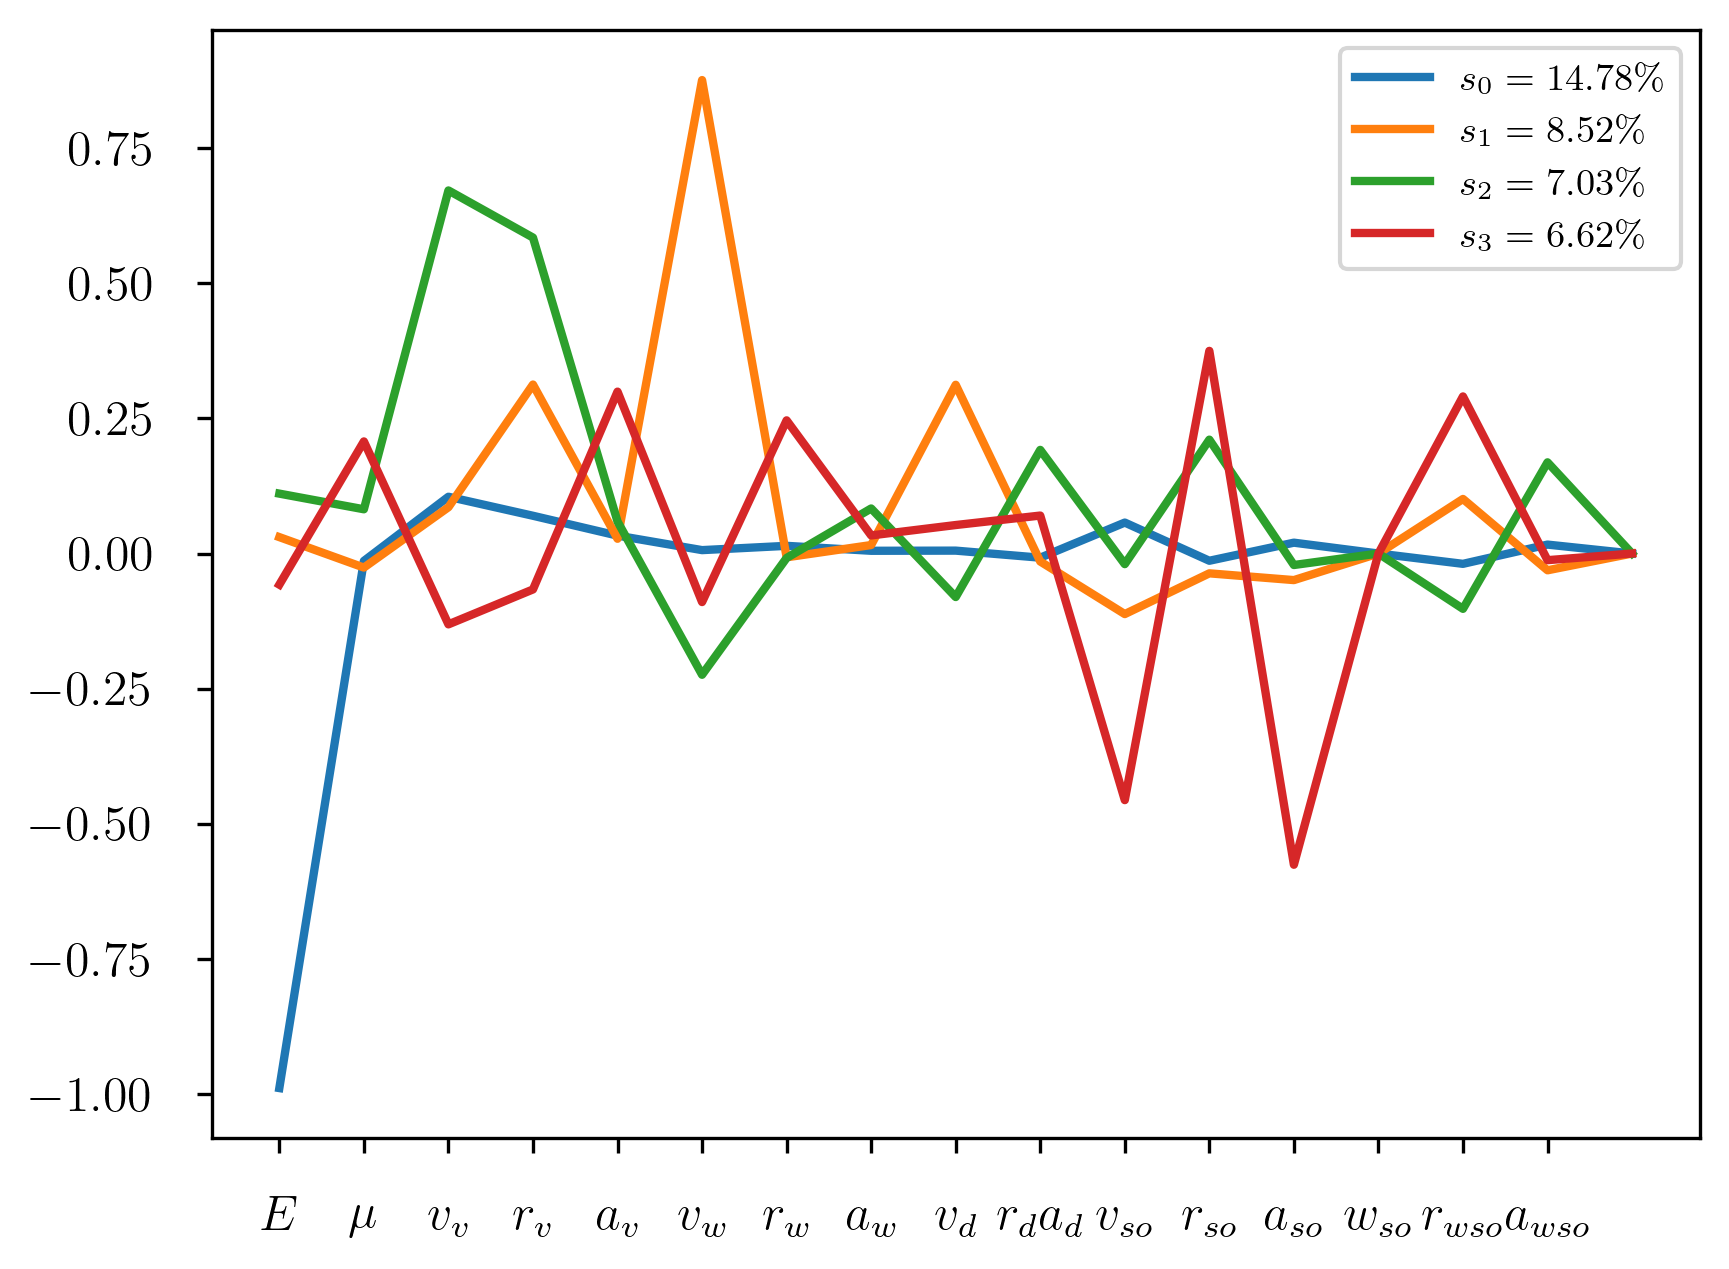

In [21]:
# vectors in param space with largest variance of gradient wrt smatrix training set
f, ax = plt.subplots(facecolor="white", dpi=300)
for i in range(4):
    s = S[i] ** 2 / np.sum(S**2) * 100
    plt.plot(list(range(17)), U[:,i], label=f"$s_{i} = {s:.2f}\%$")
ax.xaxis.set_ticks(list(range(16)))
ax.xaxis.set_ticklabels(
    [
        r"$E$",
        r"$\mu$",
        r"$v_v$",
        r"$r_v$",
        r"$a_v$",
        r"$v_w$",
        r"$r_{w}$",
        r"$a_{w}$",
        r"$v_d$",
        r"$r_{d}$"
        r"$a_d$",
        r"$v_{so}$", 
        r"$r_{so}$",
        r"$a_{so}$",
        r"$w_{so}$",
        r"$r_{wso}$",
        r"$a_{wso}$",

    ]
)
plt.legend()

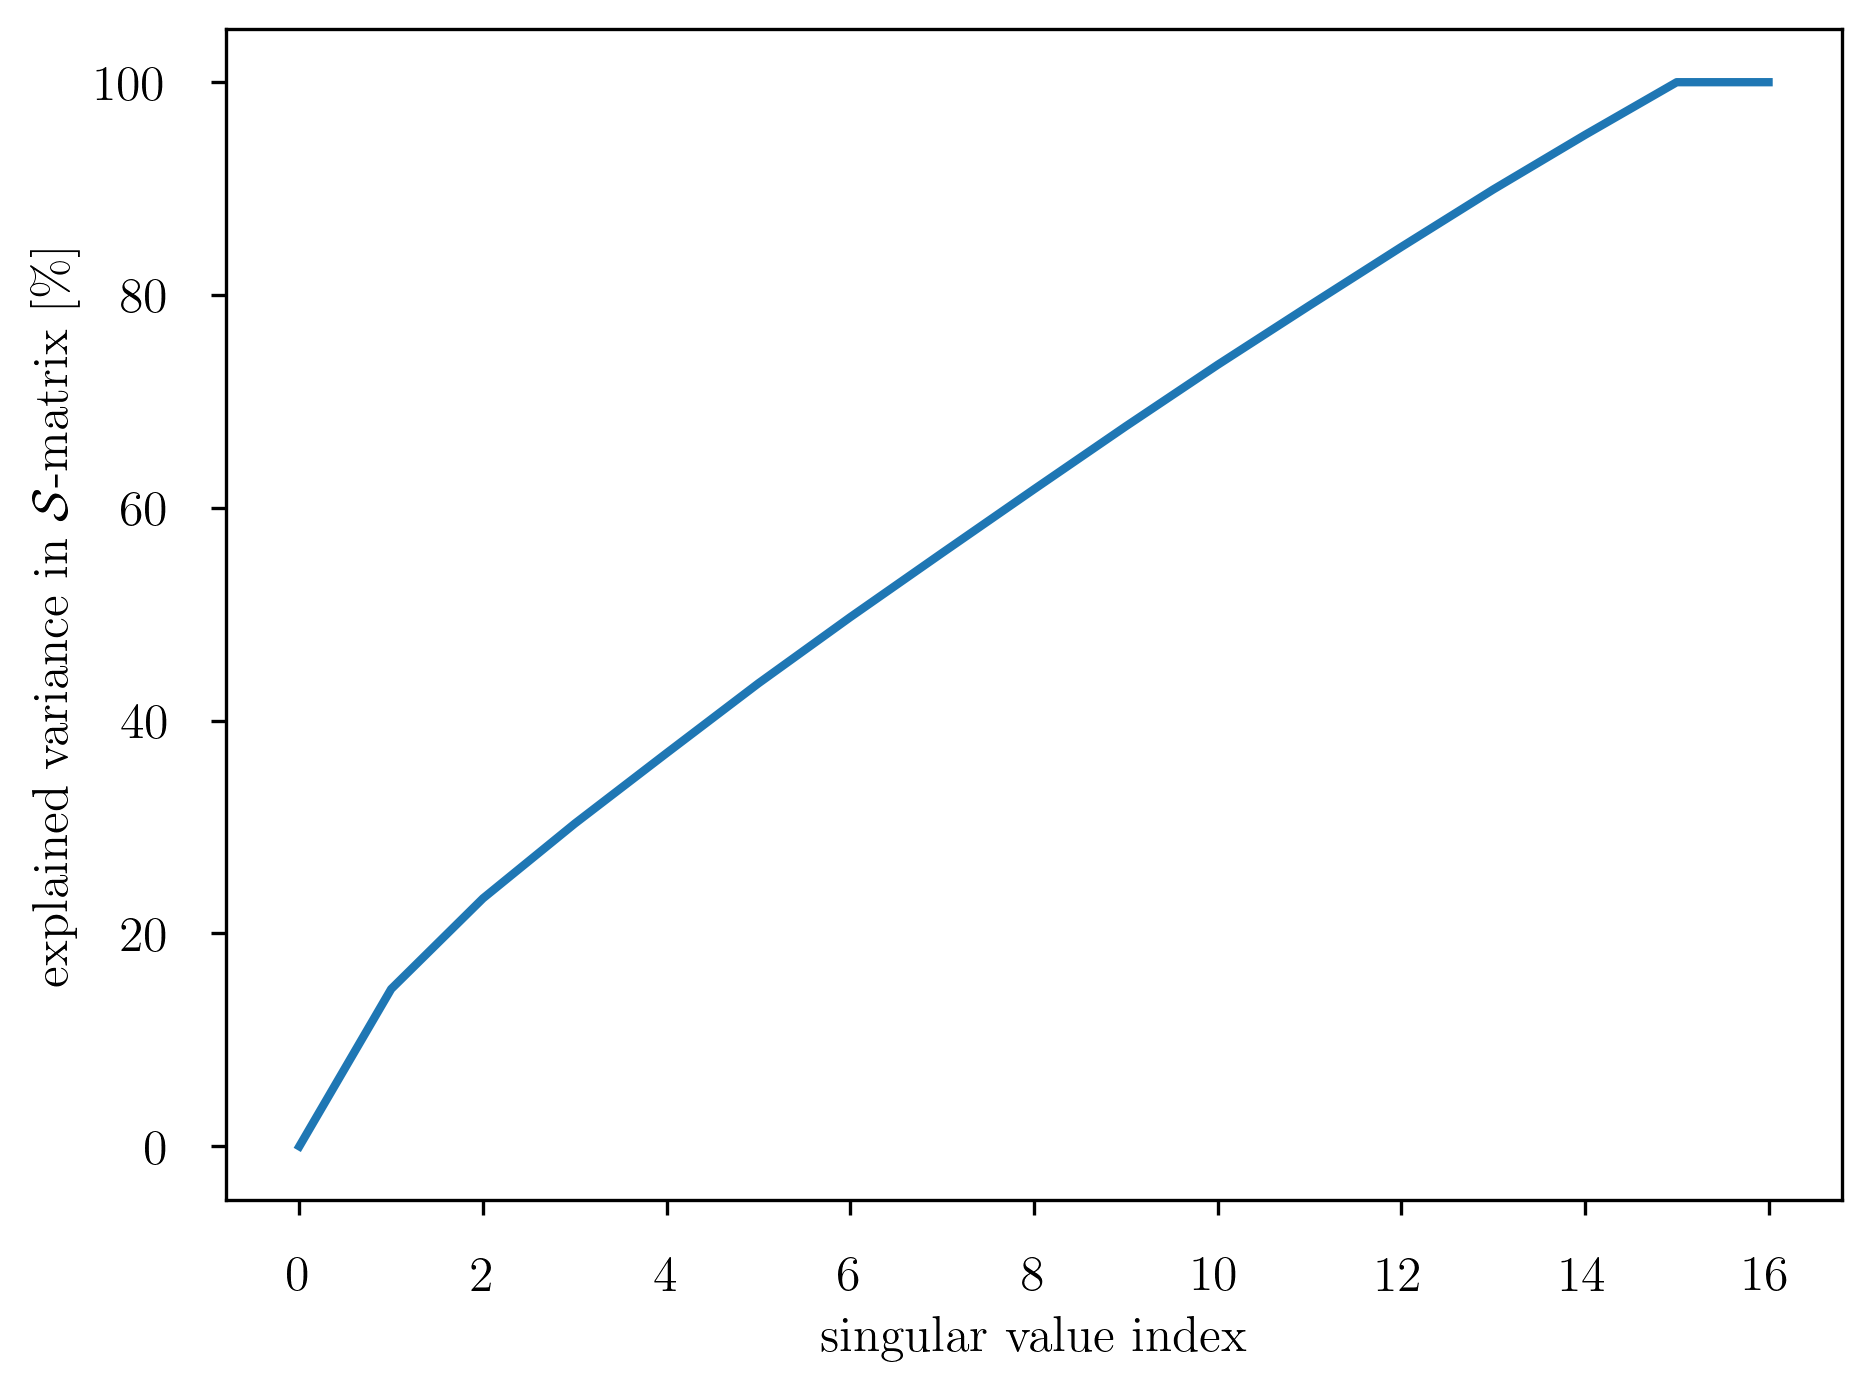

In [22]:
f = plt.figure(facecolor="white", dpi=300)
plt.plot(
    list(range(len(S))), 
    100*np.array([np.sum(S[:i]**2) for i in range(len(S))]) / np.sum(S**2)
)
#plt.ylim([1e-8,100])
plt.xlabel("singular value index")
plt.ylabel("explained variance  in $\mathcal{S}$-matrix [\%]")
plt.tight_layout()

## Construct a kd-tree for training points rotated into the active subspace

In [23]:
ndims = 3
train_as = np.array(
    [ U[:, :ndims].T @ pre_process(sample) for sample in train]
)

/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (


In [ ]:
active_subspace_kdtree = kdtree.KDTree(train_as)

def get_active_subspace_nns(sample, knn=1):
    x = U[:,:ndims].T @ pre_process(sample)
    dists, idxs = active_subspace_kdtree.query(x, k=knn)
    return dists, idxs

/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (


[(0.02109815656654385, 439), (0.06836687047870729, 1443), (0.07295083449403274, 1753), (0.08085927720558231, 168)]


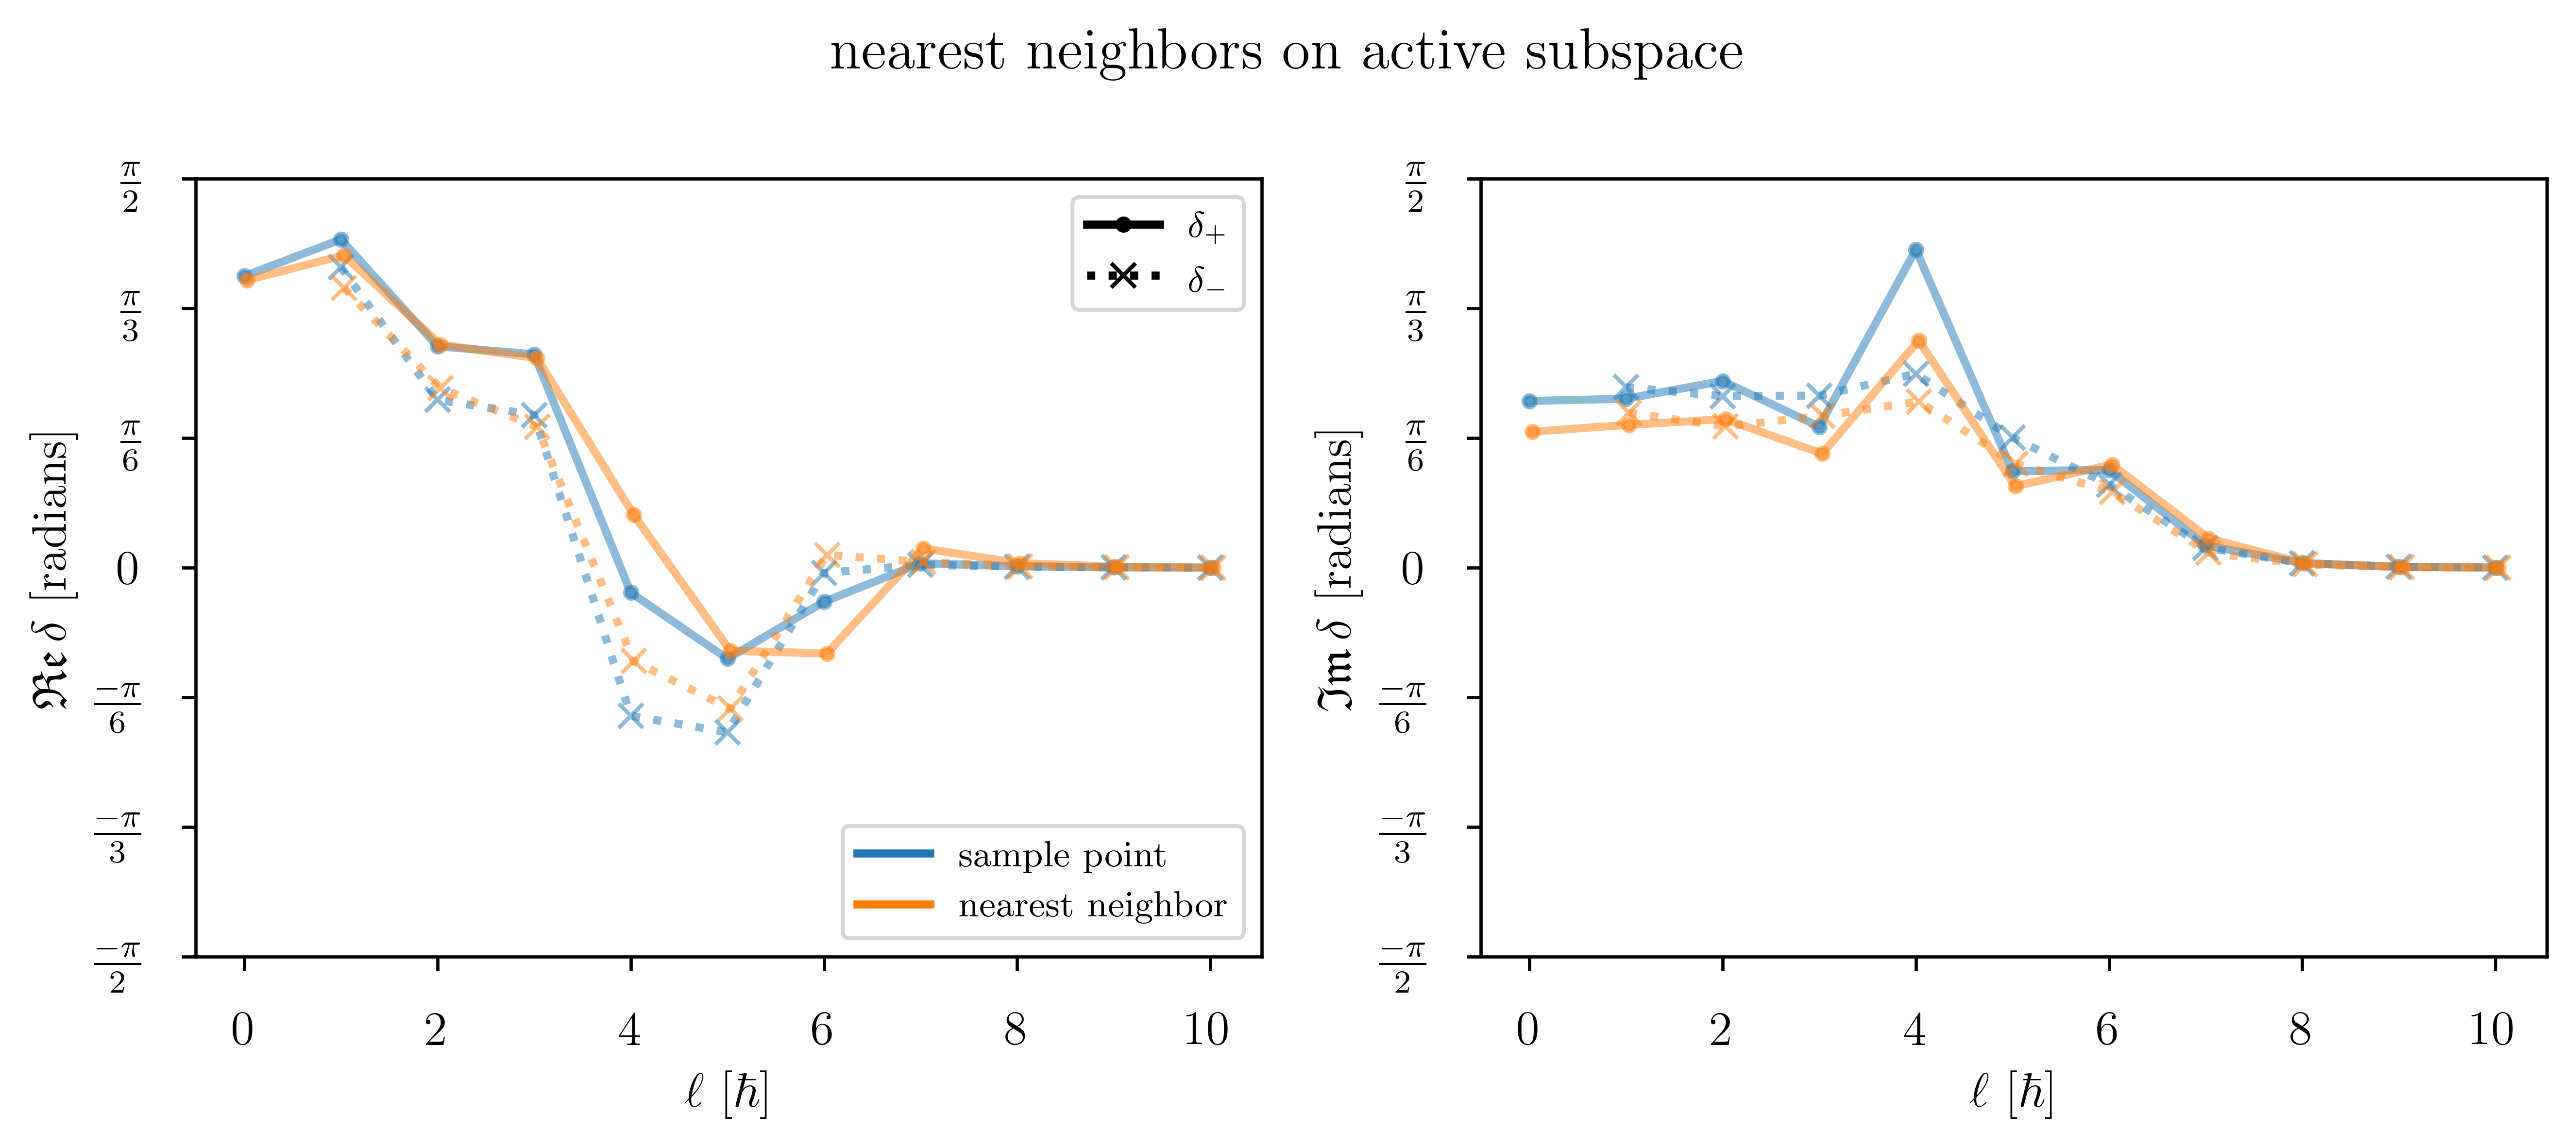

In [25]:
# samples in the training space that are close together in the active subspace
# produce very similar responses (e.g. s-matrix elements and phase shifts)

i = 0
# get nearest active subspace neighbors to first training sample
dists, idxs = get_active_subspace_nns(train[i], knn=5)
dists = dists[1:]
idxs = idxs[1:] # ignore the input point
print([(d, i) for d, i in zip(dists, idxs)])

# get phase shifts of neighbors to first training sample
ps0 = sae.exact_phase_shifts(train[i])
psneighbor = sae.exact_phase_shifts(train[idxs[0]])

from rose.training import compare_phase_shifts

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=600)
fig.patch.set_facecolor("white")

compare_phase_shifts(
    [ps0, psneighbor], ["sample point", "nearest neighbor"], fig, ax1, ax2
)
ax1.set_ylim([-np.pi / 2, np.pi / 2])
ax2.set_ylim([-np.pi / 2, np.pi / 2])
fig.suptitle("nearest neighbors on active subspace")
plt.tight_layout()
plt.savefig("nn_active_phase_shifts.pdf")

[(946.1156895928391, 895), (946.1176115045592, 1120), (946.1206958913373, 718), (946.125402271472, 345)]


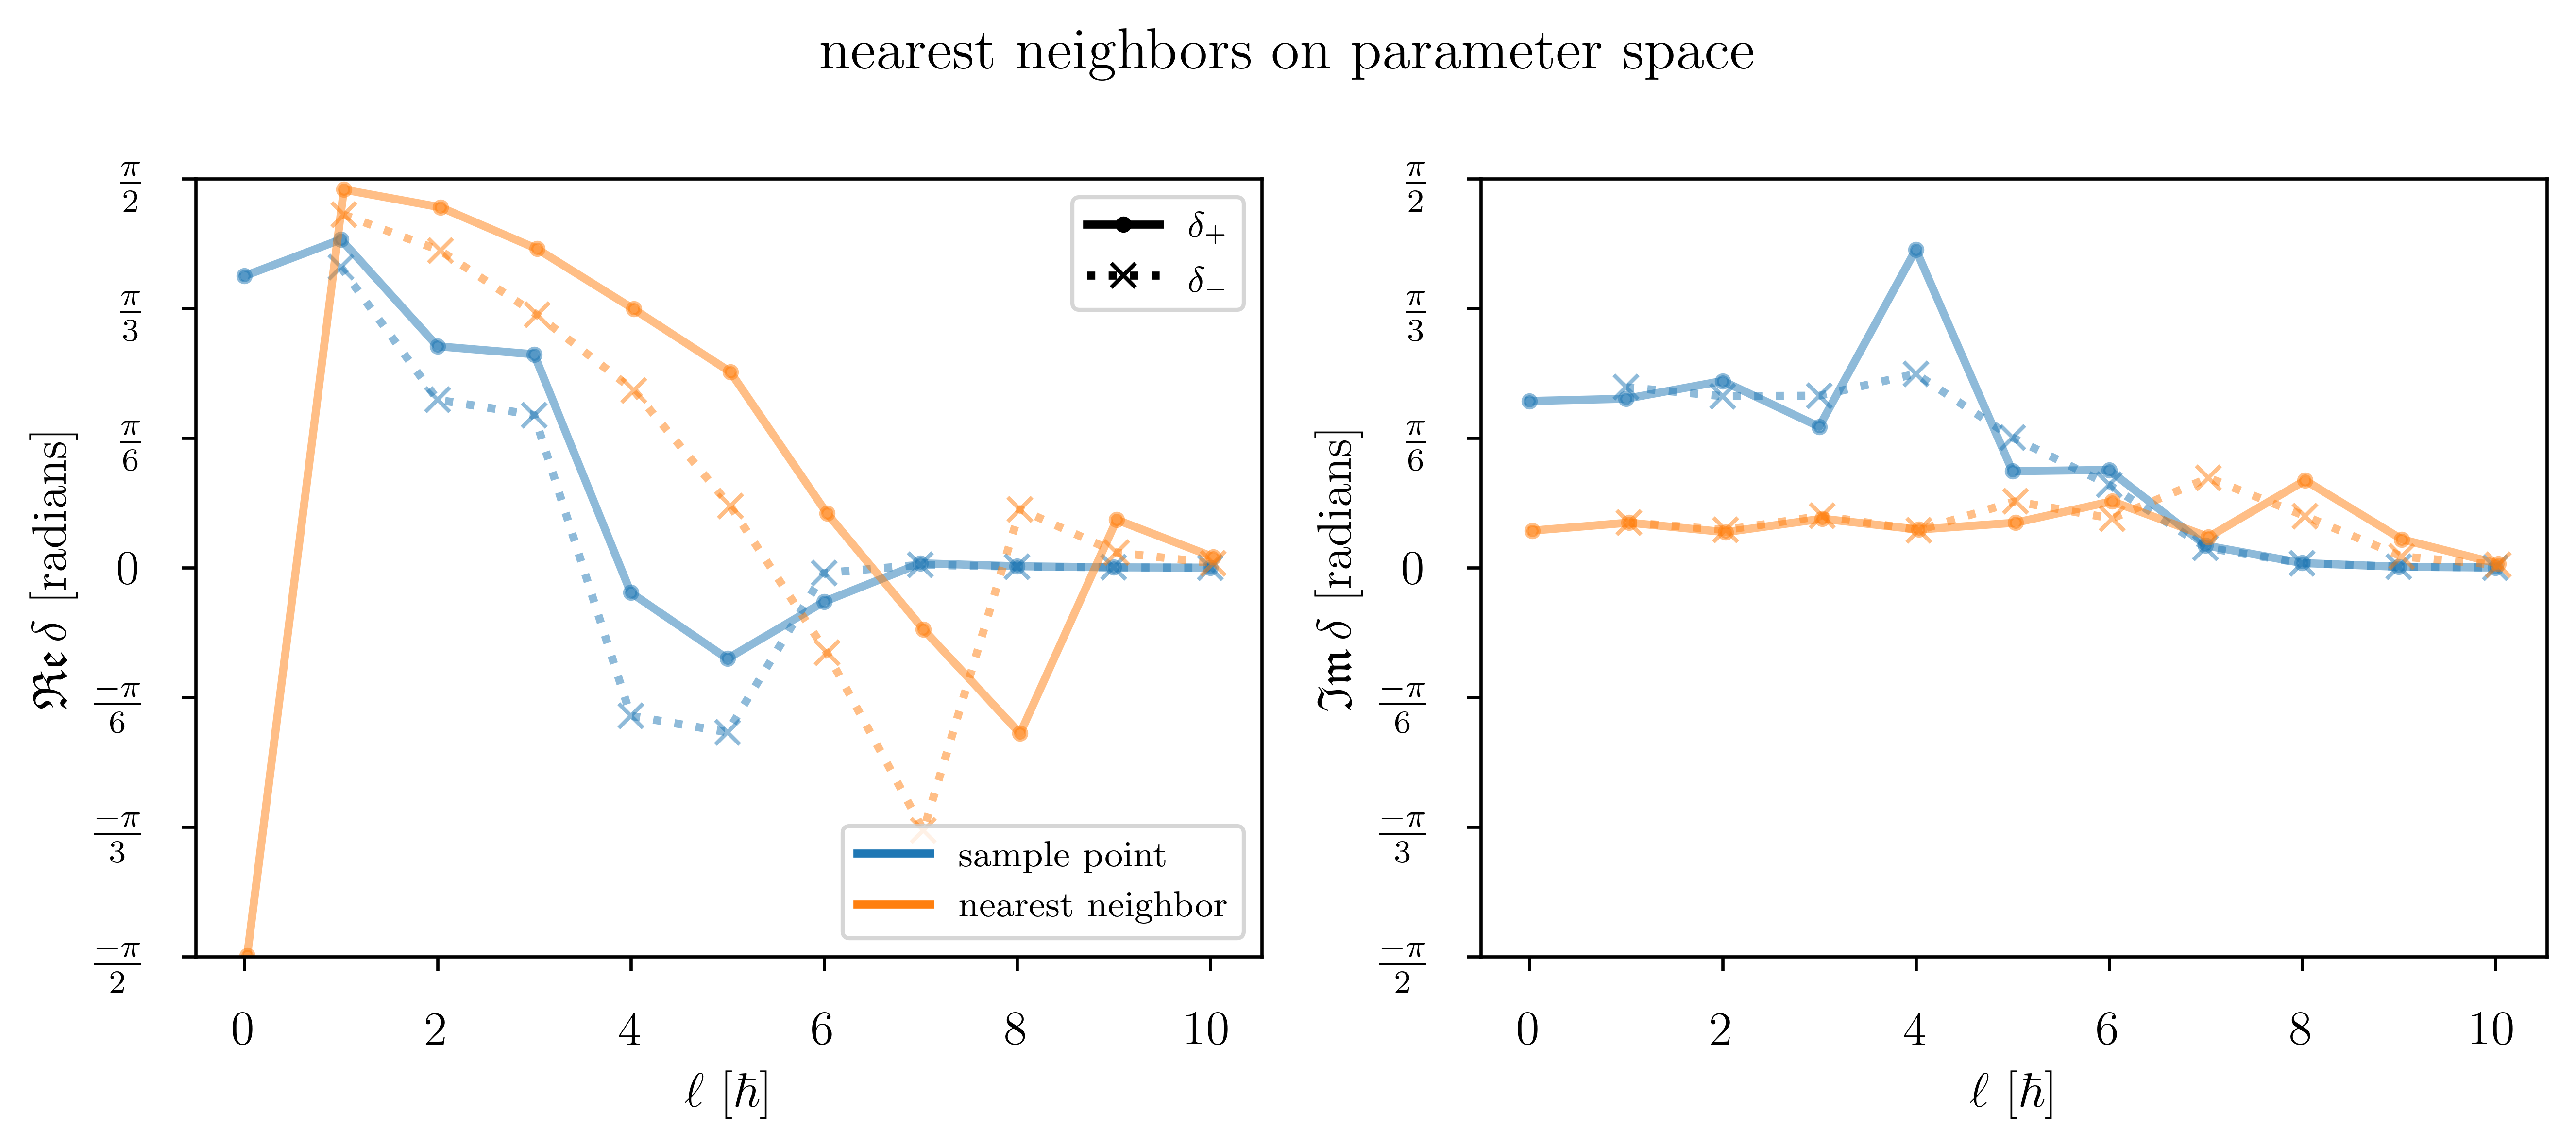

In [26]:
# samples in the training space that are close together may not
i = 0
# get nearest active subspace neighbors to first training sample
dists, idxs = tree.query(train[i], k=5)
dists = dists[1:]
idxs = idxs[1:] # ignore the input point
print([(d, i) for d, i in zip(dists, idxs)])

# get phase shifts of neighbors to first training sample
ps0 = sae.exact_phase_shifts(train[i])
psneighbor = sae.exact_phase_shifts(train[idxs[0]])

from rose.training import compare_phase_shifts

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=600)
fig.patch.set_facecolor("white")

compare_phase_shifts(
    [ps0, psneighbor], ["sample point", "nearest neighbor"], fig, ax1, ax2
)
ax1.set_ylim([-np.pi / 2, np.pi / 2])
ax2.set_ylim([-np.pi / 2, np.pi / 2])
fig.suptitle("nearest neighbors on parameter space")
plt.tight_layout()
plt.savefig("nn_param_space_phase_shifts.pdf")

(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

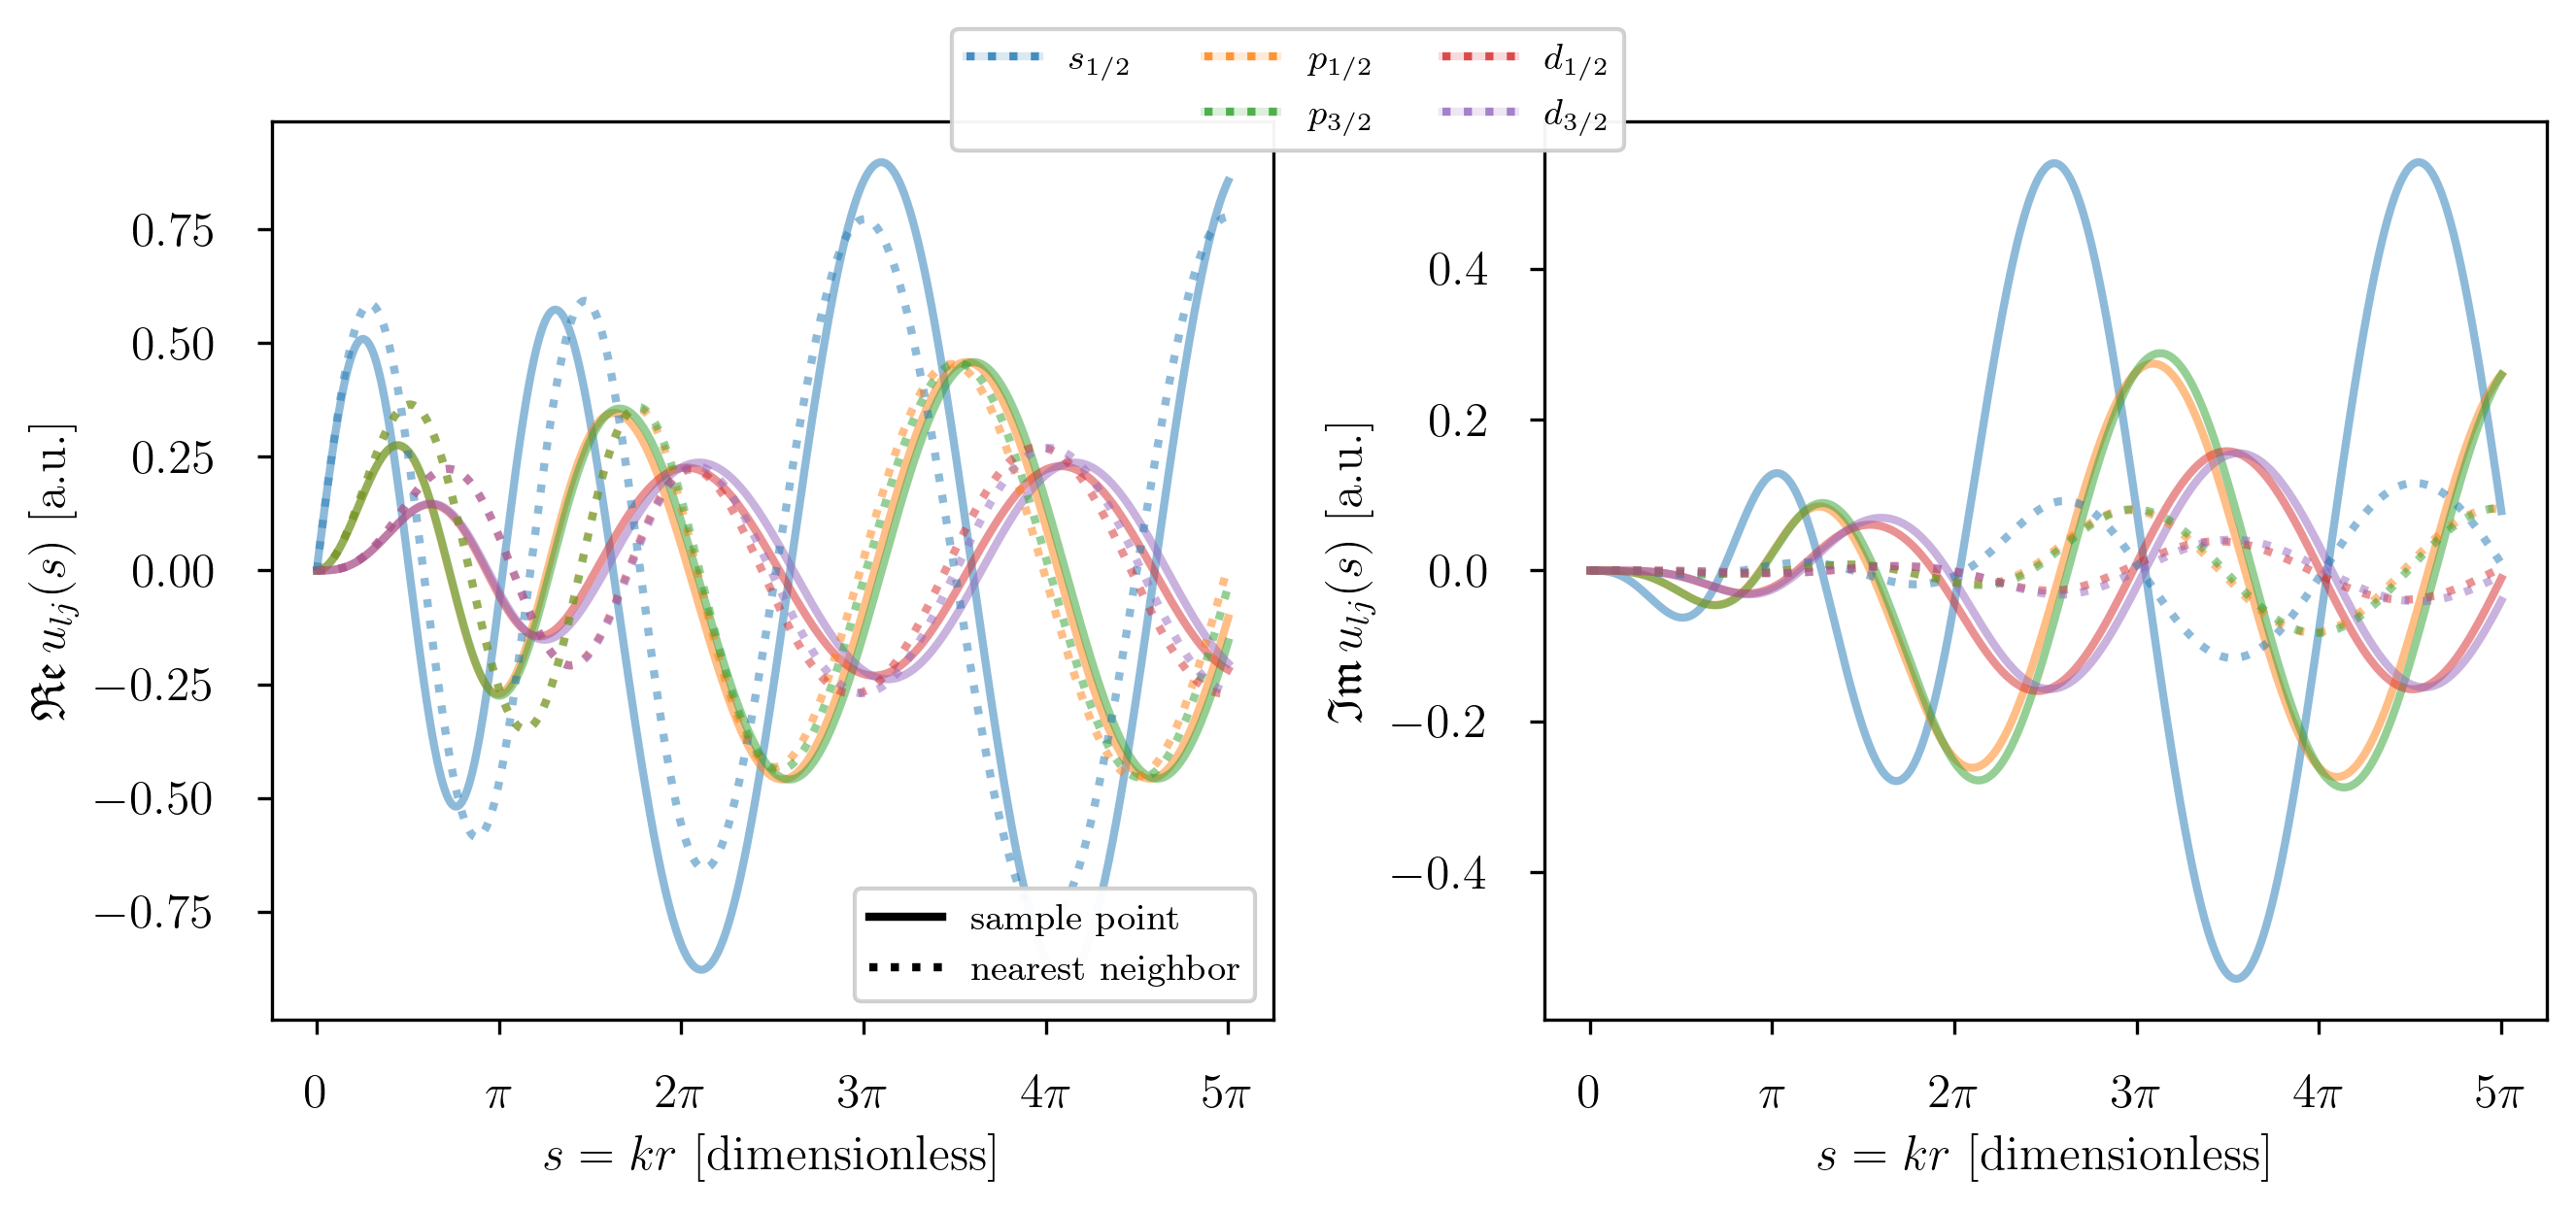

In [27]:
ps0 = sae.exact_wave_functions(train[i])
psneighbor = sae.exact_wave_functions(train[idxs[0]])

from rose.training import compare_partial_waves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh, [ps0[:3], psneighbor[:3]], ["sample point", "nearest neighbor"], fig, ax1, ax2
)

## Evenly sample a set of points on the parameter space to act as tangent points

In [28]:
# we can do this by randomly selecting a set of points on the original param space
size = 100
tangent_points = rose.training.latin_hypercube_sample(size, log_energy_bounds, seed=99)
tangent_points[:,0] = np.exp(tangent_points[:,0])
active_subspace_tangent_points = np.array(
    [ U[:, :ndims].T @ pre_process(sample) for sample in tangent_points]
)
tangent_point_tree = kdtree.KDTree(active_subspace_tangent_points)

def closest_tangent_point(sample):
    return tangent_point_tree.query( U[:, :ndims].T @ pre_process(sample) )

def get_training_neighborhood(tangent_point, size):
    return get_active_subspace_nns(tangent_point, size)

/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (
/tmp/ipykernel_46051/1430114949.py:8: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  tangent_point_tree = kdtree.KDTree(active_subspace_tangent_points)


## Test out a single tangent space

In [29]:
# for testing convenience
test_transformed = [ U[:,:ndims].T @ pre_process(sample) for sample in test]
test_tree = kdtree.KDTree(test_transformed)

/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (
/tmp/ipykernel_46051/742798070.py:3: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  test_tree = kdtree.KDTree(test_transformed)


In [30]:
tangent_point = tangent_points[9]
size=150
dists, neighborhood = get_training_neighborhood(tangent_point, size=size)
ds, test_neighborhood = test_tree.query( U[:,:ndims].T @ pre_process(tangent_point), k=10)

/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (


In [31]:
int_test = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=train[neighborhood,:],
    explicit_training=True,
    n_basis=20,
    l_max=l_max,
    rho_mesh=s_mesh,
)

/home/kyle/mambaforge/envs/om/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


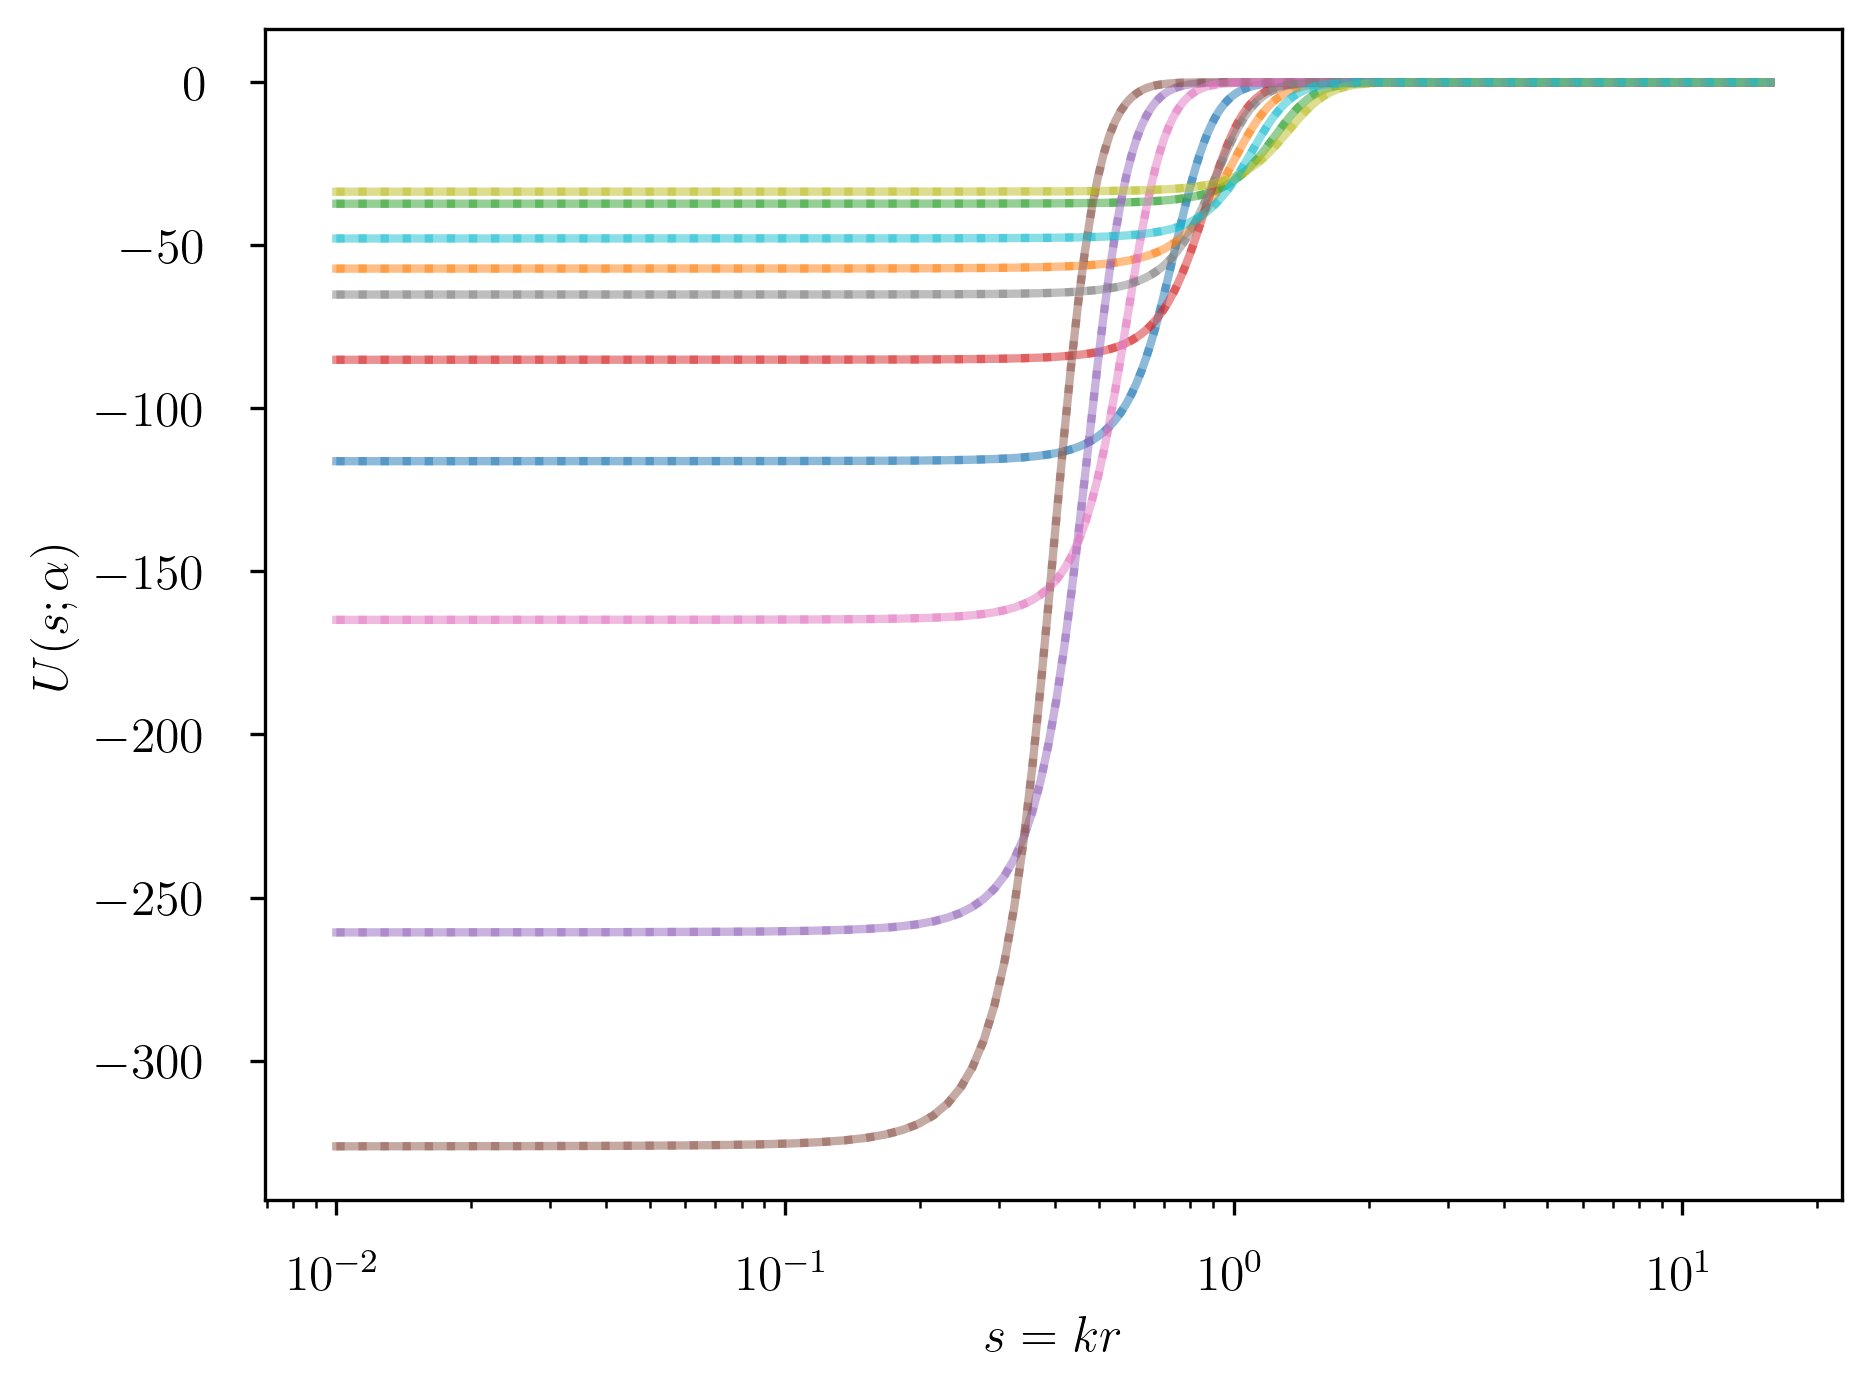

In [32]:
f = plt.figure(facecolor="white", dpi=300)
for sample in test[test_neighborhood]:
    p = plt.plot(s_mesh, int_test.interactions[0][0].tilde(s_mesh, sample), alpha=0.5)[
        0
    ]
    plt.plot(
        s_mesh,
        int_test.interactions[0][0].tilde_emu(s_mesh, sample),
        ":",
        alpha=0.5,
        color=p.get_color(),
    )

plt.ylabel(r"$U(s; \alpha)$")
plt.xlabel(r"$s = kr$")
plt.xscale("log")
plt.tight_layout()

In [33]:
sae_test = rose.ScatteringAmplitudeEmulator.from_train(
    interaction_space=int_test,
    alpha_train=train[neighborhood,:],
    base_solver=rose.SchroedingerEquation.make_base_solver(s_0=s_0, domain=domain),
    l_max=l_max,
    angles=angles,
    use_svd=True,
    scale=True,
    s_mesh=s_mesh,
    n_basis=20,
)

100%|███████████████████████████████████████████| 11/11 [01:34<00:00,  8.63s/it]
/home/kyle/umich/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)


/tmp/ipykernel_46051/3733121905.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  exact_wf[i][j] *= em_wf[i][j][40] / exact_wf[i][j][40]
/tmp/ipykernel_46051/3733121905.py:7: RuntimeWarning: invalid value encountered in multiply
  exact_wf[i][j] *= em_wf[i][j][40] / exact_wf[i][j][40]


(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

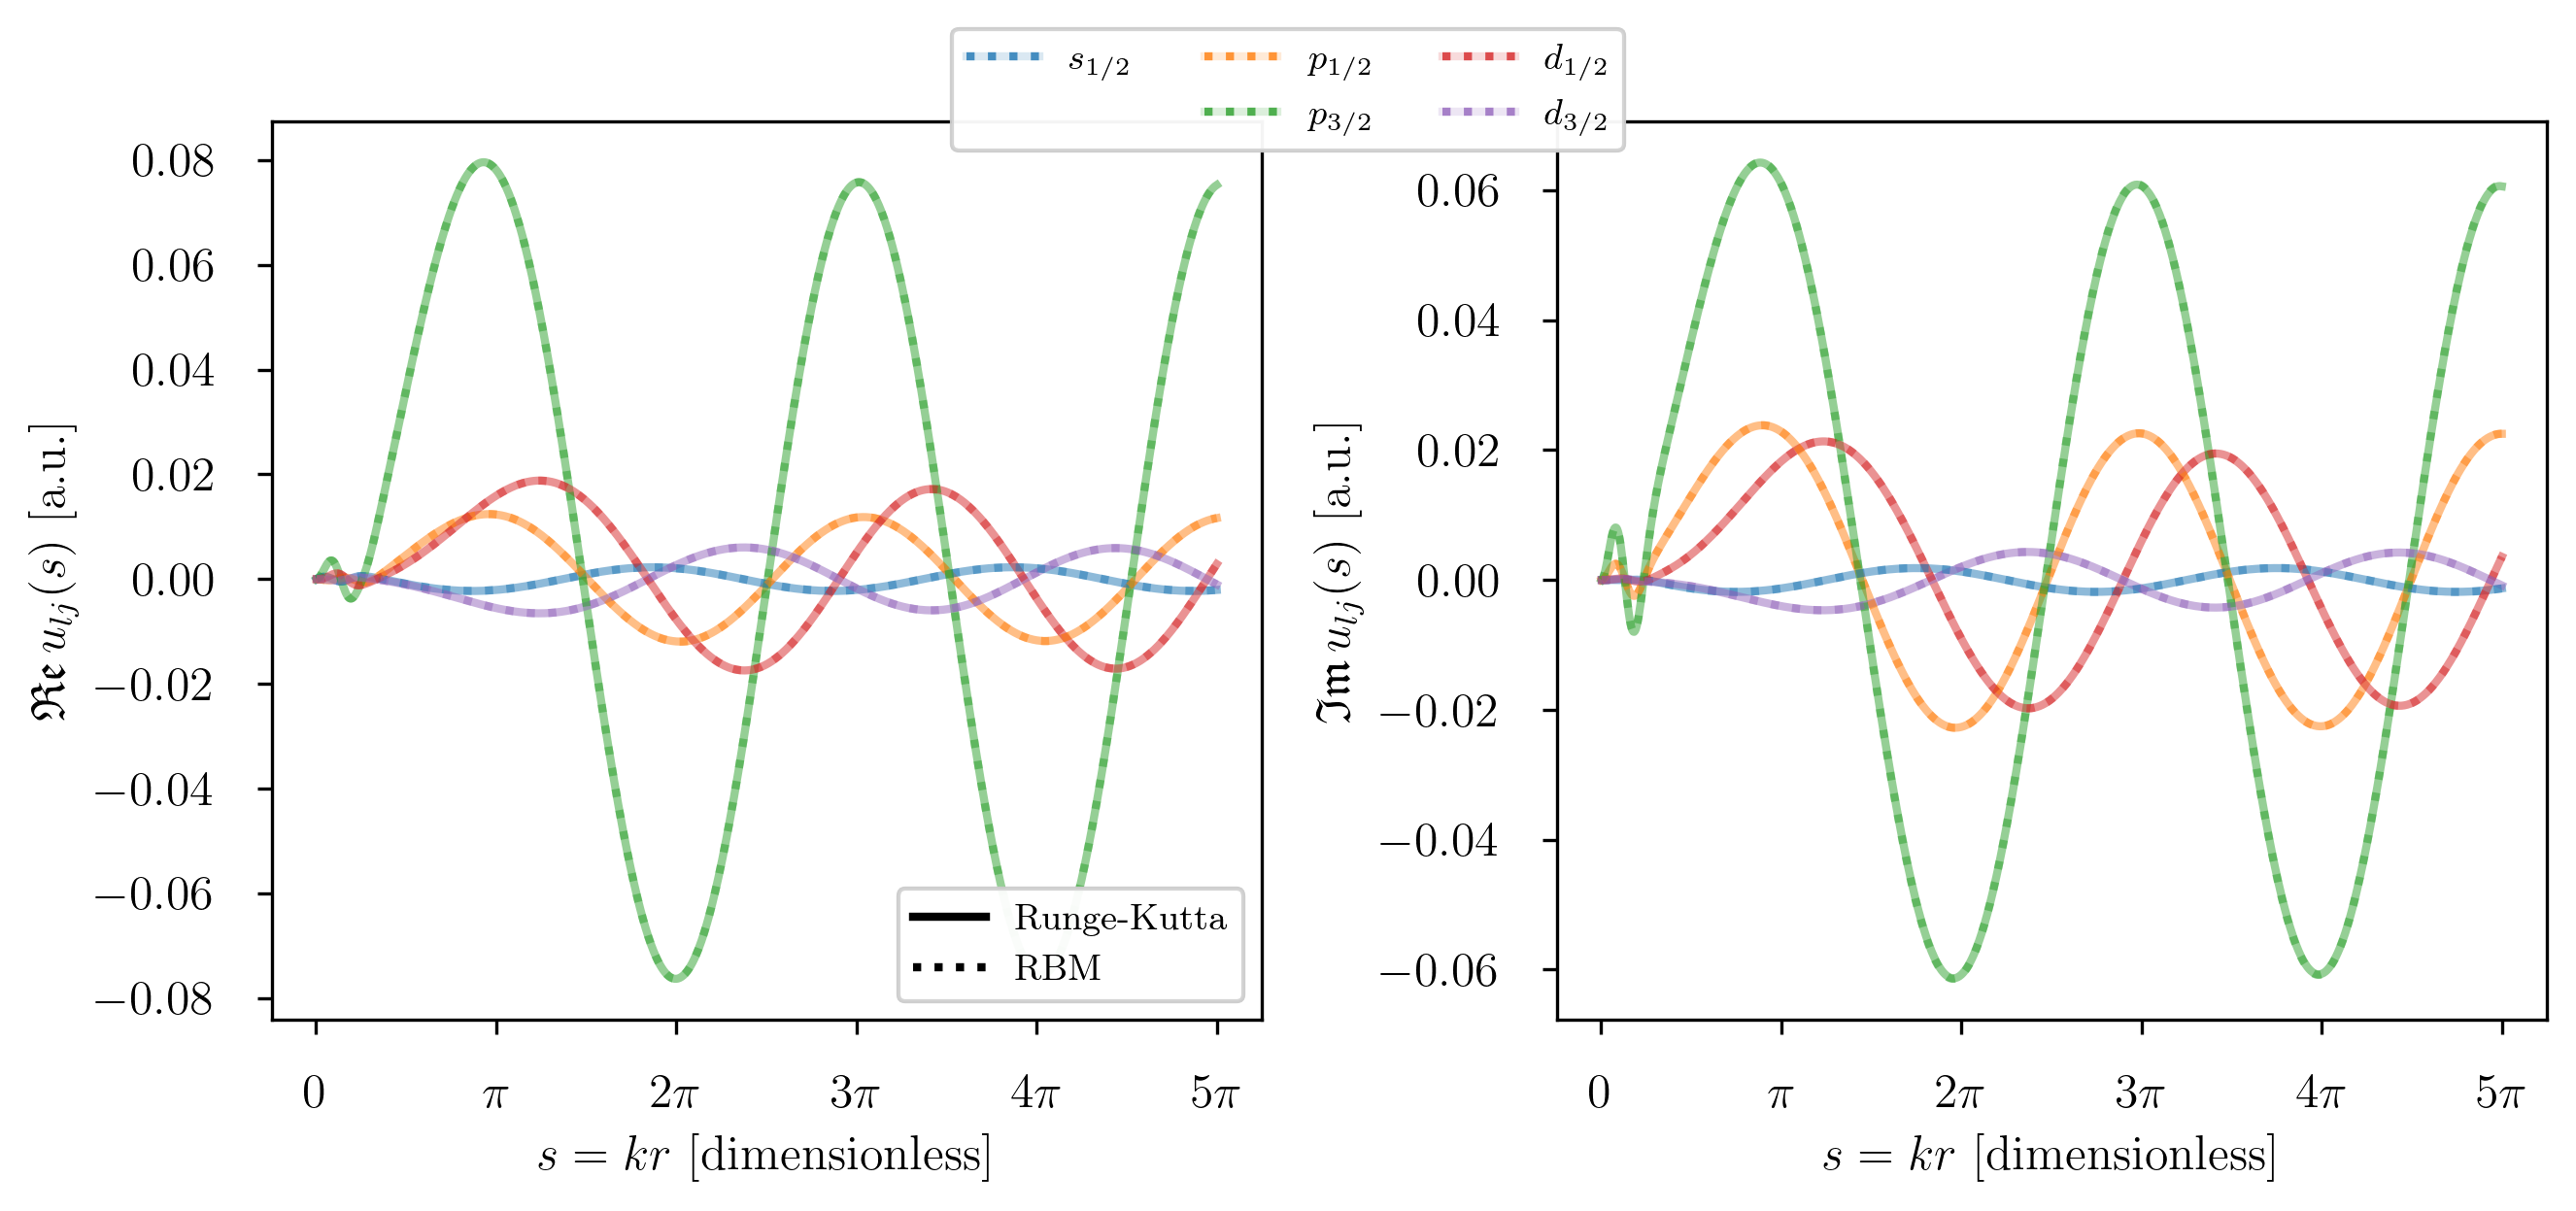

In [34]:
test_pt = test[test_neighborhood[0]]
exact_wf = sae_test.exact_wave_functions(test_pt)
em_wf = sae_test.emulate_wave_functions(test_pt)

for i in range(len(exact_wf)):
    for j in range(len(exact_wf[i])):
        exact_wf[i][j] *= em_wf[i][j][40] / exact_wf[i][j][40]

from rose.training import compare_partial_waves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh, [exact_wf[:3], em_wf[:3]], ["Runge-Kutta", "RBM"], fig, ax1, ax2
)

(-1.5707963267948966, 1.5707963267948966)

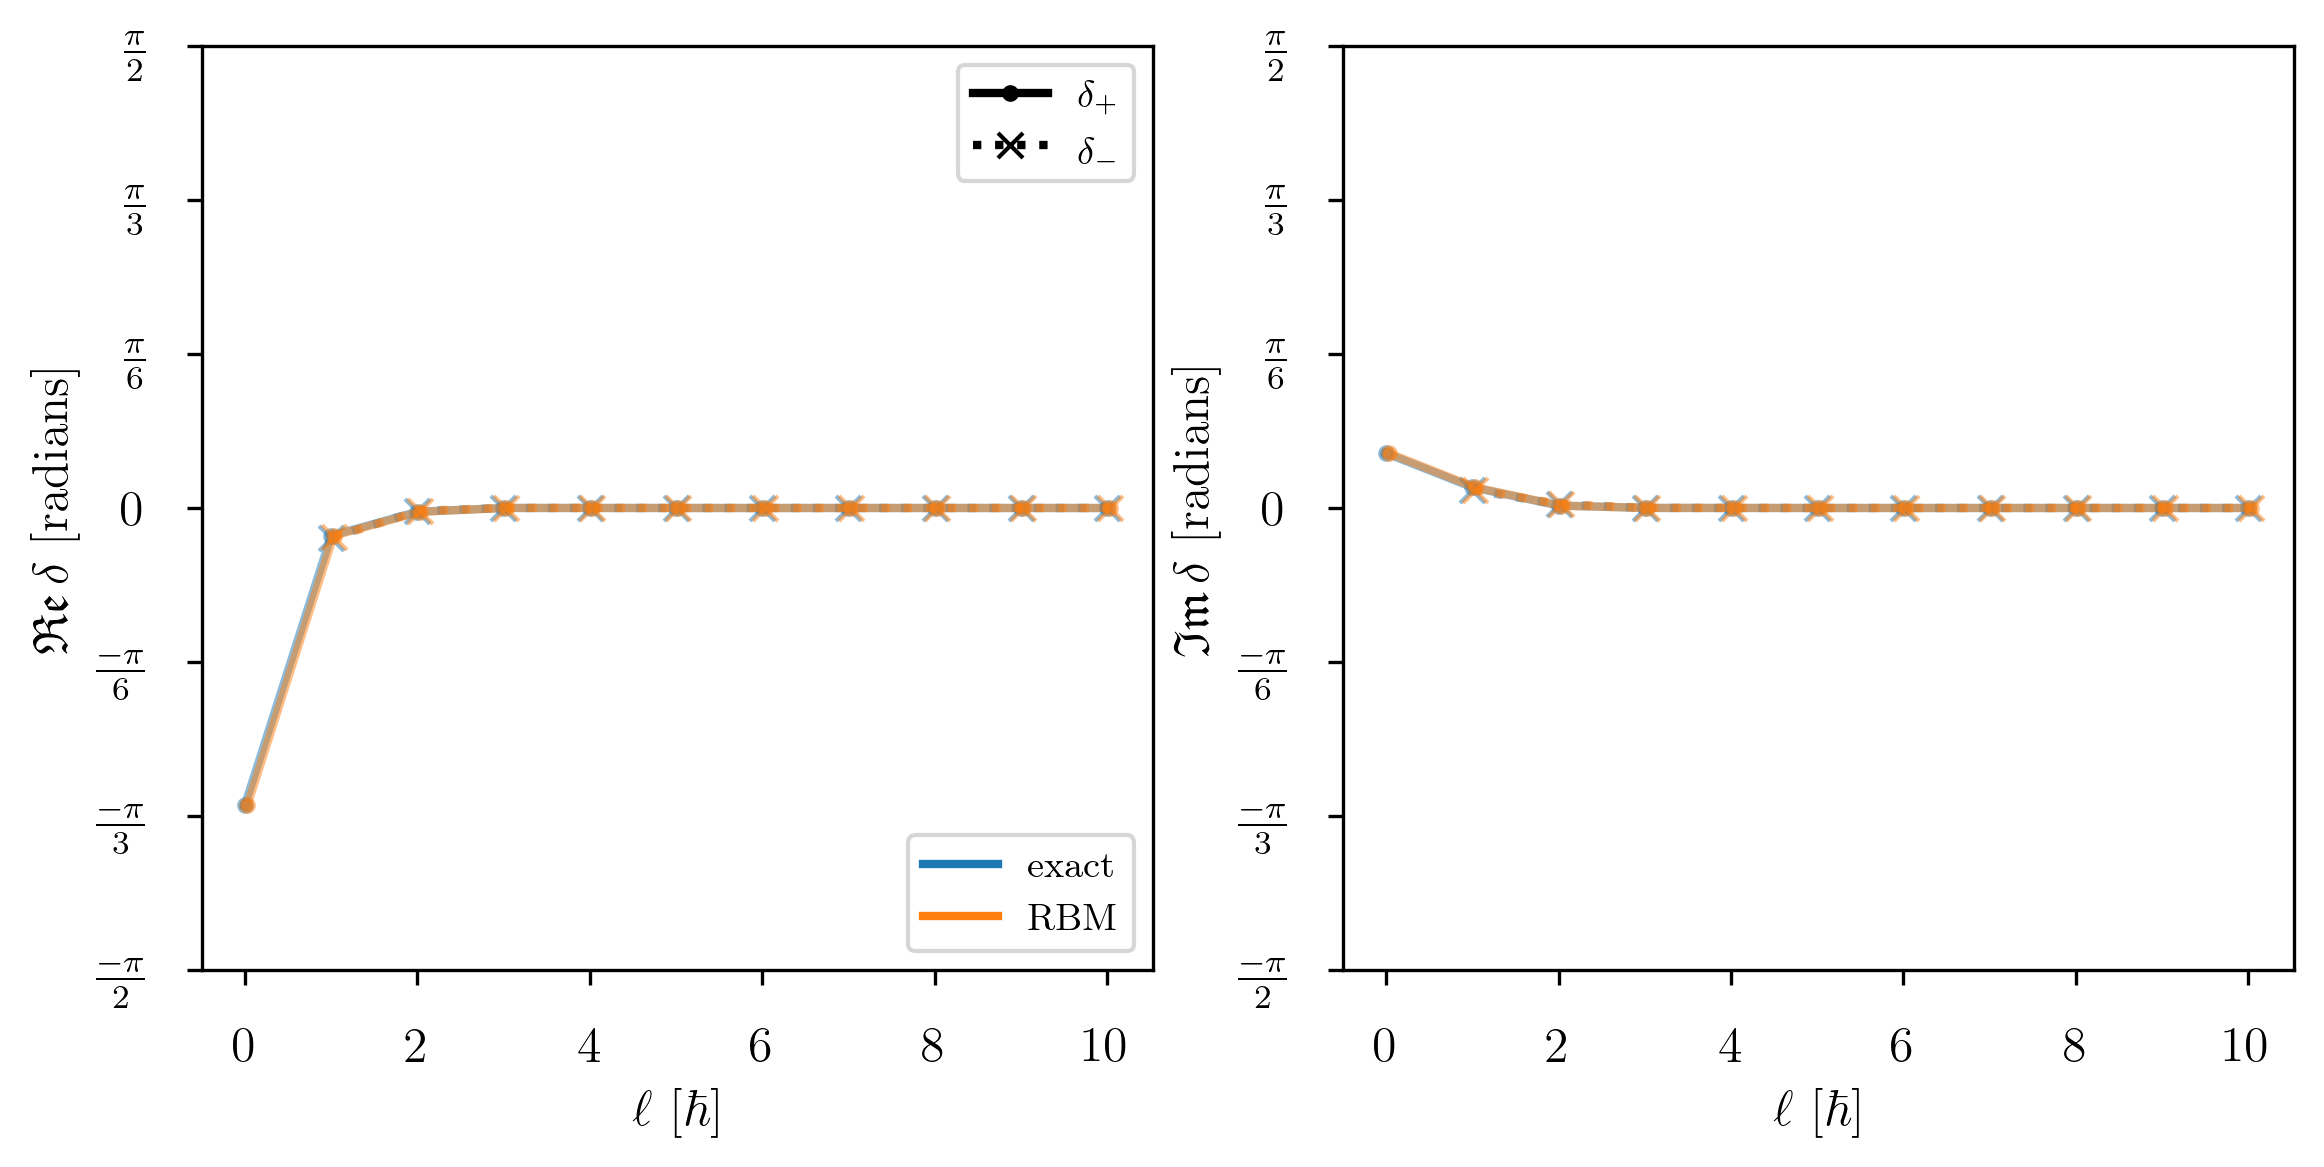

In [35]:
exact_wf  = sae_test.exact_phase_shifts(test_pt)
em_wf = sae_test.emulate_phase_shifts(test_pt)

from rose.training import compare_phase_shifts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_phase_shifts([exact_wf, em_wf], ["exact", "RBM"], fig, ax1, ax2)
ax1.set_ylim([-np.pi/2, np.pi/2])
ax2.set_ylim([-np.pi/2, np.pi/2])

In [36]:
exact_dsdo = []
for d, t in zip(ds, test[test_neighborhood]):
    print(d)
    exact_dsdo.append(sae_test.exact_dsdo(t))

0.13833519142873874
0.1398205125073857
0.15442603186331944
0.15493986708500362
0.16765533369398797
0.17108640882379572
0.1753281348577692
0.20643005609453563
0.21826126506235322
0.230780941150943


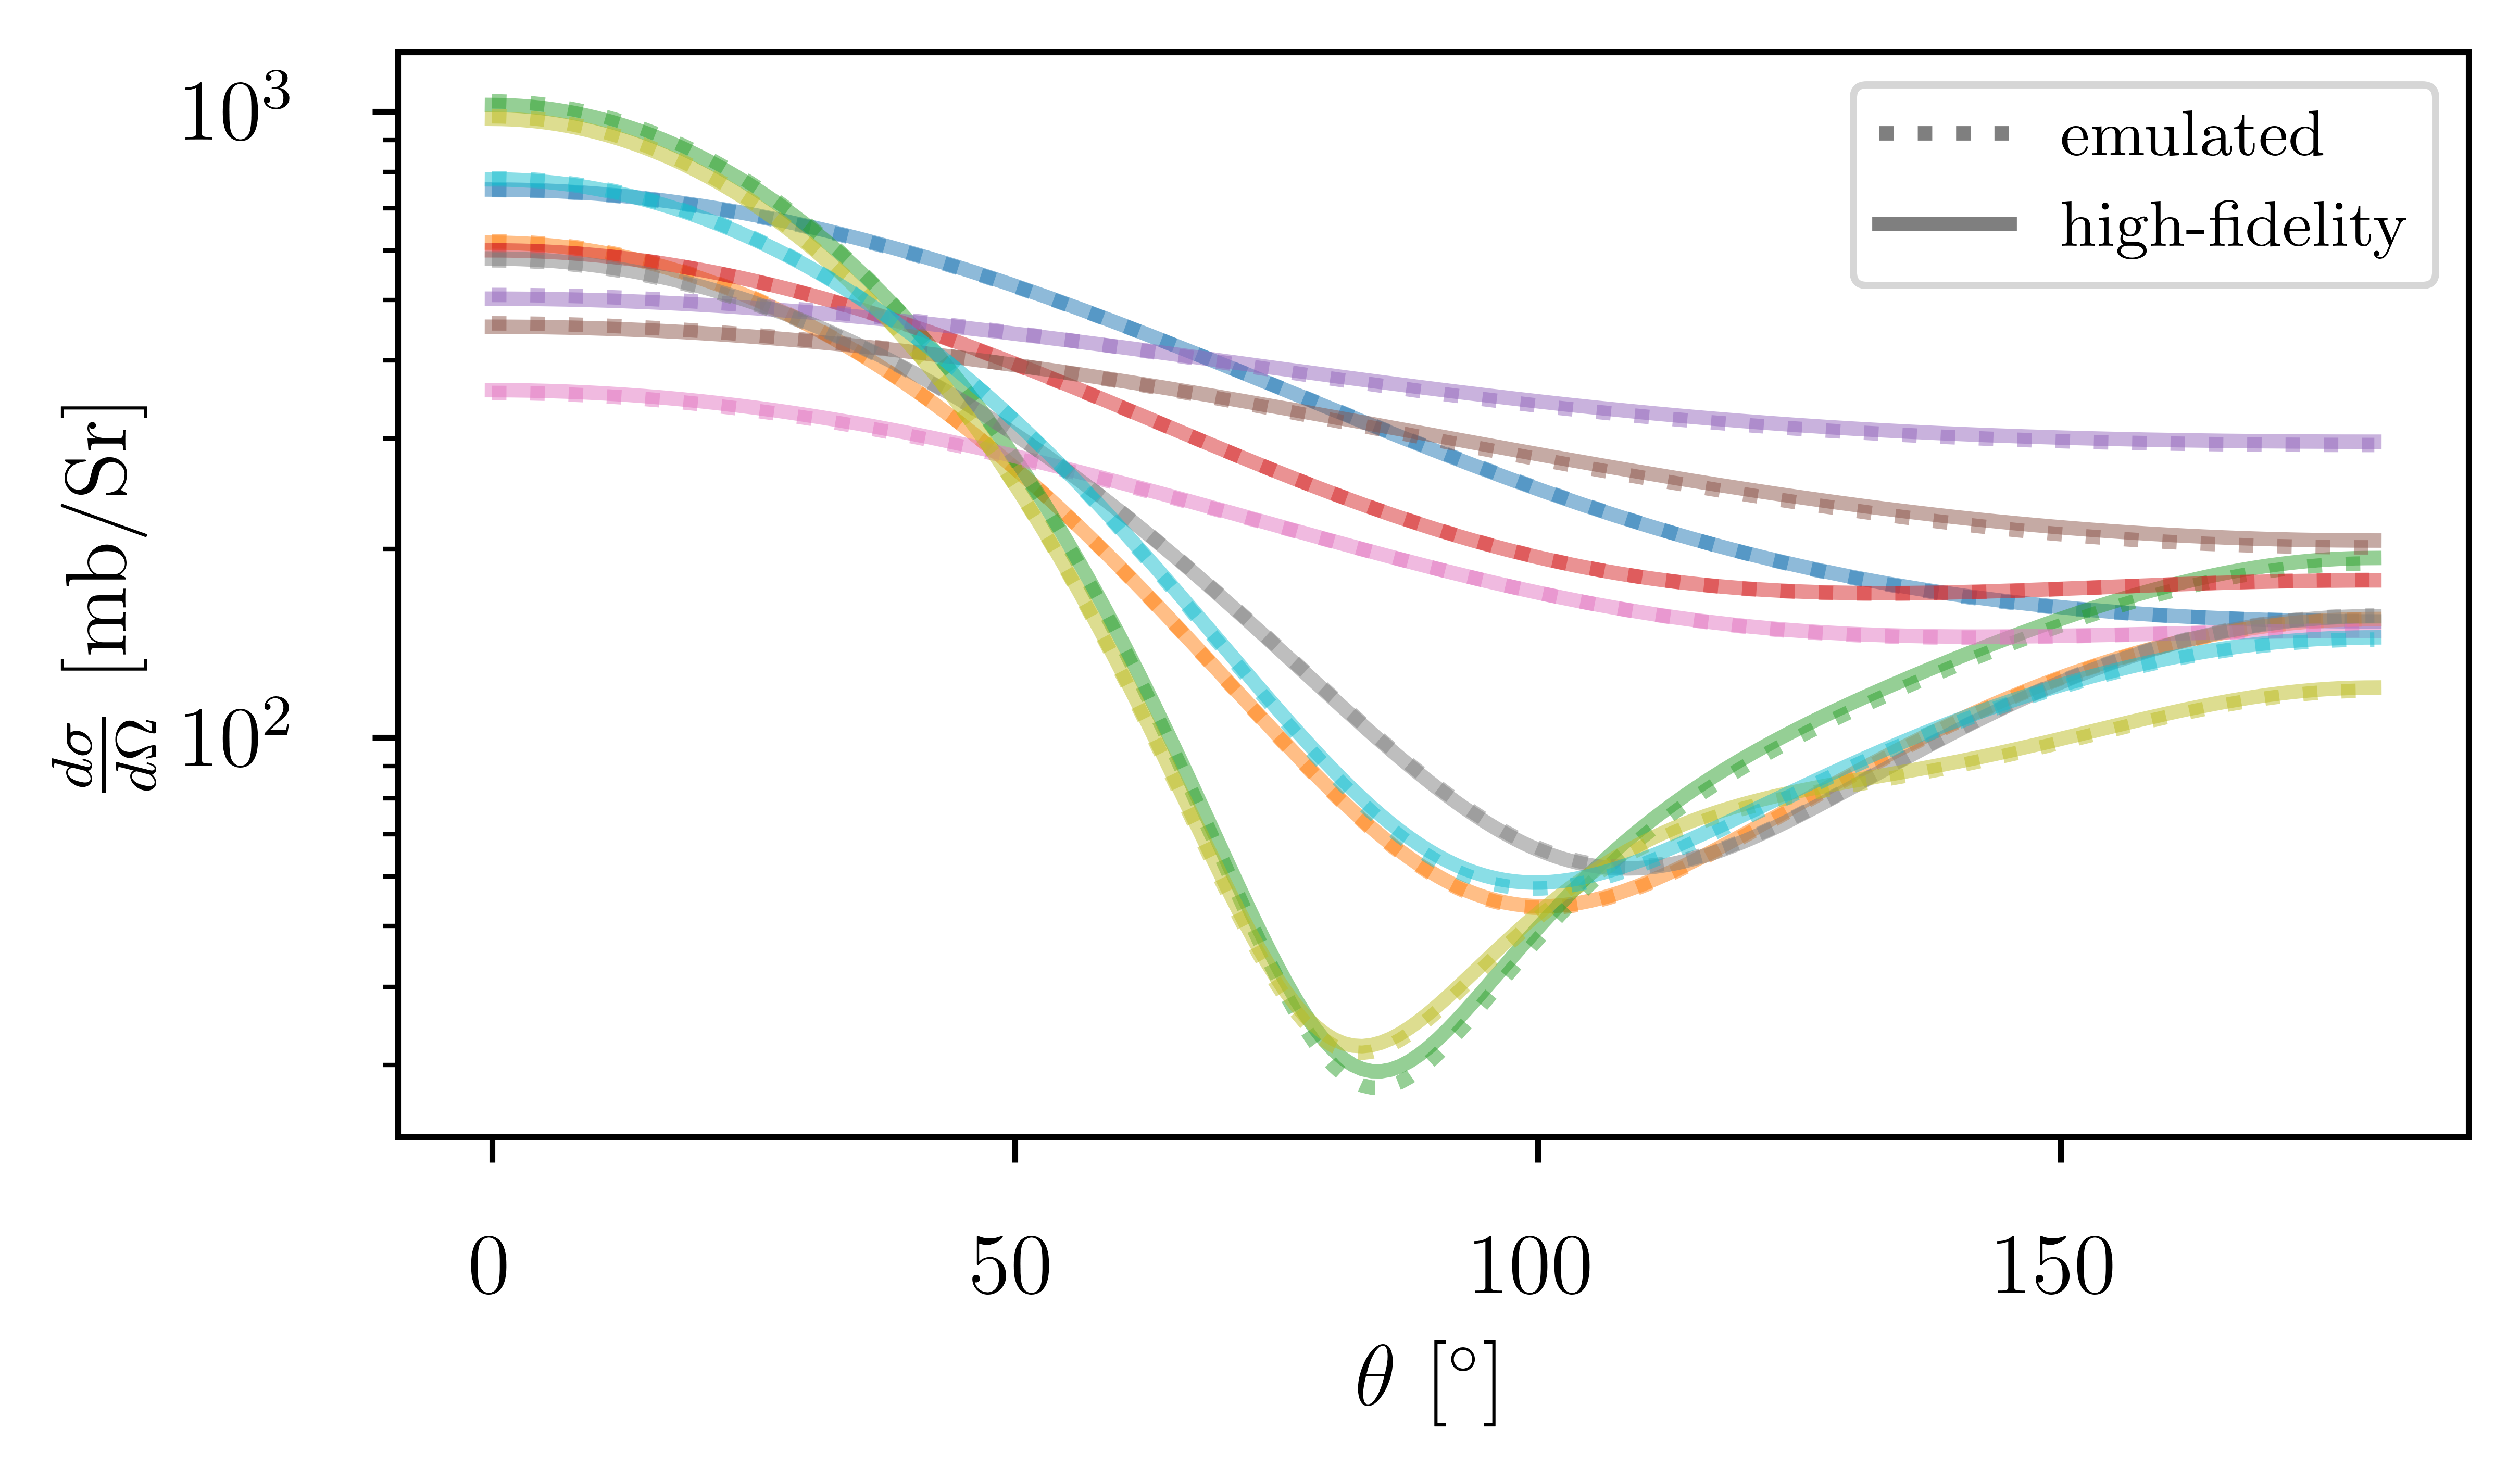

In [37]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=1000)
fig.patch.set_facecolor("white")
emulator = sae_test
for i, sample in enumerate(test[test_neighborhood]):
    x = angles * 180 /np.pi
    
    # HIFI
    y_exact = exact_dsdo[i]
    
    # emulated
    y_emu = sae_test.emulate_dsdo(sample)

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=12)
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ [mb/Sr]", fontsize=12)
plt.yscale("log")
plt.tight_layout()

## Construct Active Subspace Quilt

In [ ]:
nbasis = 20
neim = 20
knn = 100

def make_bases(ids, interactions):
    bases = []
    for l in range(l_max):
        bup = rose.CustomBasis(
            hf_solns_up[ids, l, :].T,
            free_solns[l, :],
            s_mesh,
            nbasis,
            solver=rose.SchroedingerEquation(
                interactions.interactions[l][0],
                s_0=s_0,
                domain=domain,
            ),
            use_svd=True,
            scale=True,
        )
        if l == 0:
            bases.append([bup])
        else:
            bdown = rose.CustomBasis(
                hf_solns_down[ids, l, :].T,
                free_solns[l, :],
                s_mesh,
                nbasis,
                solver=rose.SchroedingerEquation(
                    interactions.interactions[l][1],
                    s_0=s_0,
                    domain=domain,
                ),
                use_svd=True,
                scale=True,
            )
            bases.append([bup, bdown])
    return bases


emulators = []
interactions = []
for i in tqdm(range(len(tangent_points))):
    dists, neighborhood = get_training_neighborhood(tangent_point, size=knn)
    interactions.append(
        rose.EnergizedKoningDelaroche(
            training_info=train[neighborhood, :],
            n_basis=neim,
            l_max=l_max,
            explicit_training=True,
            rho_mesh=s_mesh,
        )
    )
    bases = make_bases(neighborhood, interactions[-1])
    emulators.append(
        rose.ScatteringAmplitudeEmulator(
            interaction_space=interactions[-1],
            bases=bases,
            angles=angles,
            s_0=s_0,
        )
    )

  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_46051/1800520247.py:12: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (
 94%|███████████████████████████████████████▍  | 94/100 [10:11<01:27, 14.62s/it]

In [ ]:
# plot one set of bases, for a single voxel and a single partial wave
f = plt.figure(facecolor="white", dpi=300)
b = emulators[0].rbes[0][0].basis # which voxel and partial wave to look at?
for phi in b.vectors.T:
    p = plt.plot(s_mesh, phi.real, alpha=0.5)[0]
    plt.plot(s_mesh, phi.imag, ":", alpha=0.5, color=p.get_color())

plt.plot(s_mesh, b.phi_0, "k", label=r"$F_l(\eta, kr)$")
plt.ylabel(r"$\phi(s;\alpha)$")
plt.xlabel(r"$s = kr$")
plt.legend()
plt.tight_layout()

## Test performance

In [ ]:
%%time
emulated_xs = []
for sample in test:
    _, idx = midpoints_tree.query(forward_pspace_transform(sample))
    xs = emulators[idx].emulate_xs(sample)
    emulated_xs.append( xs.dsdo )

In [ ]:
%%time
if read_from_file:
    exact_xs = np.load("exact_xs_train.npy")
else:
    exact_xs = []
    for sample in test:
        xs = emulators[0].exact_xs(sample)
        exact_xs.append( xs.dsdo )
    np.save("exact_xs_train.npy", np.asarray(exact_xs))

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(5, 3), dpi=1000)
fig.patch.set_facecolor("white")
emulator = emulators[9]
for i, sample in enumerate(test[:15]):
    x = s_mesh
    
    # HIFI
    y_exact = emulator.rbes[0][0].basis.solver.interaction.tilde(s_mesh, sample)

    # emulated
    y_emu = emulator.rbes[0][0].basis.solver.interaction.tilde_emu(s_mesh, sample)

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
plt.xlabel(r"s = kr", fontsize=12)
plt.ylabel(r"$U(s)$", fontsize=12)
plt.tight_layout()

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(5, 3), dpi=1000)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test[:4]):
    x = emulator.angles * 180 / (np.pi)

    # HIFI
    y_exact = exact_xs[i]

    # emulated
    y_emu = emulated_xs[i]

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=12)
plt.ylabel(r"$\frac{d \sigma}{d\Omega}$ [mb/Sr]", fontsize=12)
plt.tight_layout()
#plt.savefig("dsdo.pdf")

## Construct Binary Space Partitioning

In [ ]:
nparams = bounds.shape[0]
ndims = 3
depth = ndims*2 
size = 2**depth
print(depth, size)

In [ ]:
params_ranked = [np.argmax(v**2) for v in U.T ]
param_space_mask = np.zeros((nparams)).astype(bool)
for i in params_ranked[:ndims]:
    param_space_mask[i] = True
print(param_space_mask)

In [ ]:
bsp = BinarySPTree(
    depth,
    forward_pspace_transform(bounds[param_space_mask,0]),
    forward_pspace_transform(bounds[param_space_mask,1]),
    np.arange(0, size, 1, dtype=np.int32),
)

In [ ]:
bsp.size

In [ ]:
lbounds, ubounds = bsp.get_sub_partition_bounds()
lower = np.tile( bounds[:,0], (size,1) )
lower[:,param_space_mask] = lbounds
upper = np.tile( bounds[:,1], (size,1) )
upper[:,param_space_mask] = ubounds
midpoints = (upper + lower)/2

In [ ]:
backward_pspace_transform( lower[0] )

In [ ]:
# look at energy binning
[
    (scaleE * np.exp(l[0]), scaleE * np.exp(m[0]), scaleE * np.exp(u[0]))
    for l, m, u in zip(lower, midpoints, upper)
]

In [ ]:
midpoints_tree = kdtree.KDTree(midpoints)

In [ ]:
train_transformed = np.asarray([forward_pspace_transform(t) for t in train])
train_sorted  = bsp.sort(train_transformed, mask=param_space_mask)

In [ ]:
test_transformed = [forward_pspace_transform(t) for t in test]
test_sorted  = bsp.sort(test_transformed, mask=param_space_mask)

In [ ]:
plt.hist([len(x) for x in train_sorted])